# 🚢 TITANIC에서 살아남기

안녕하세요 DArt-B 여러분, 2025-1 정규학기 첫번째 과제는 titanic과 함께 시작하게 되었습니다.
각 팀마다 홀수 혹은 짝수 문항을 분배받아 다른 학회원 분과 함께 질문에 답을 해 나가게 되었습니다.

파이썬이 익숙하지 않거나 머신러닝 경험이 적은 분들을 위해 baseline 코드를 제공합니다.
본 코드가 가장 이상적이라고 말씀드릴 수 없습니다. 그러나 이 코드 자체로 결과물을 도출할 수 있으니, 코드 자체에 어려움을 겪기보다는 조금이라도 개인적으로 사고하고 판단하는 데에 힘을 쏟으시길 바라겠습니다.

본 코드는 코랩 작동을 기반으로 짜여진 코드입니다.

## connection to google account

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
# 코렙 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/titanic/asset/'
args.train_csv = args.default_path+'train.csv' #위의 파일 경로에다가 추가 경로만 덧붙이는 거. 이런 것이 가능하다라는 것을 알기
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []

#easydict 라이브러리를 사용하여 간단한 설정 및 변수들을 정의하고 초기화하는 작업을 수행

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)
submission = pd.read_csv(args.submission_csv)

## 데이터 파악

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
ori_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
ori_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
print(ori_train.shape) #행과 열 크기 확인
print(ori_test.shape)

(891, 12)
(418, 11)


In [ ]:
print(ori_train.columns) #Survived 존재
print(ori_test.columns) #Survived 없음

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [ ]:
ori_train.info()
#info()를 통해 전체 row 수, 칼럼별 데이터타입, 데이터타입의 null 여부, 칼럼 타입 등을 확인할 수 있습니다.
#Age, Cabin, Embarked에 대해 null 값이 존재합니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
print(ori_train.isnull().sum())
print('---------')
print(ori_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [ ]:
ori_train.describe()
#데이터의 분포도를 아는 것은 머신러닝 알고리즘의 성능을 향상시킵니다.
#회귀에서 결정값이 정규 분포를 이루지 않고 왜곡되는 경우, 이상치가 많은 경우 예측 성능이 저하됩니다.
#(describe 매서드로 정확한 분포도를 알 순 없지만) 개략적 수준의 분포도를 알 수 있어 유리합니다.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
pclass_value = ori_train['Pclass'].value_counts()
pclass_value

,count
Pclass,
3,491
1,216
2,184


# EDA

전처리에 앞서, 데이터의 분포를 확인하면
다중공선성에 의문을 제기하거나, 결측치 대체 방법에 대한 힌트를 얻을 수 있습니다. 또한 가설 검정 전, 나의 가설이 검정할 가치가 있는지를 확인할 수도 있습니다.

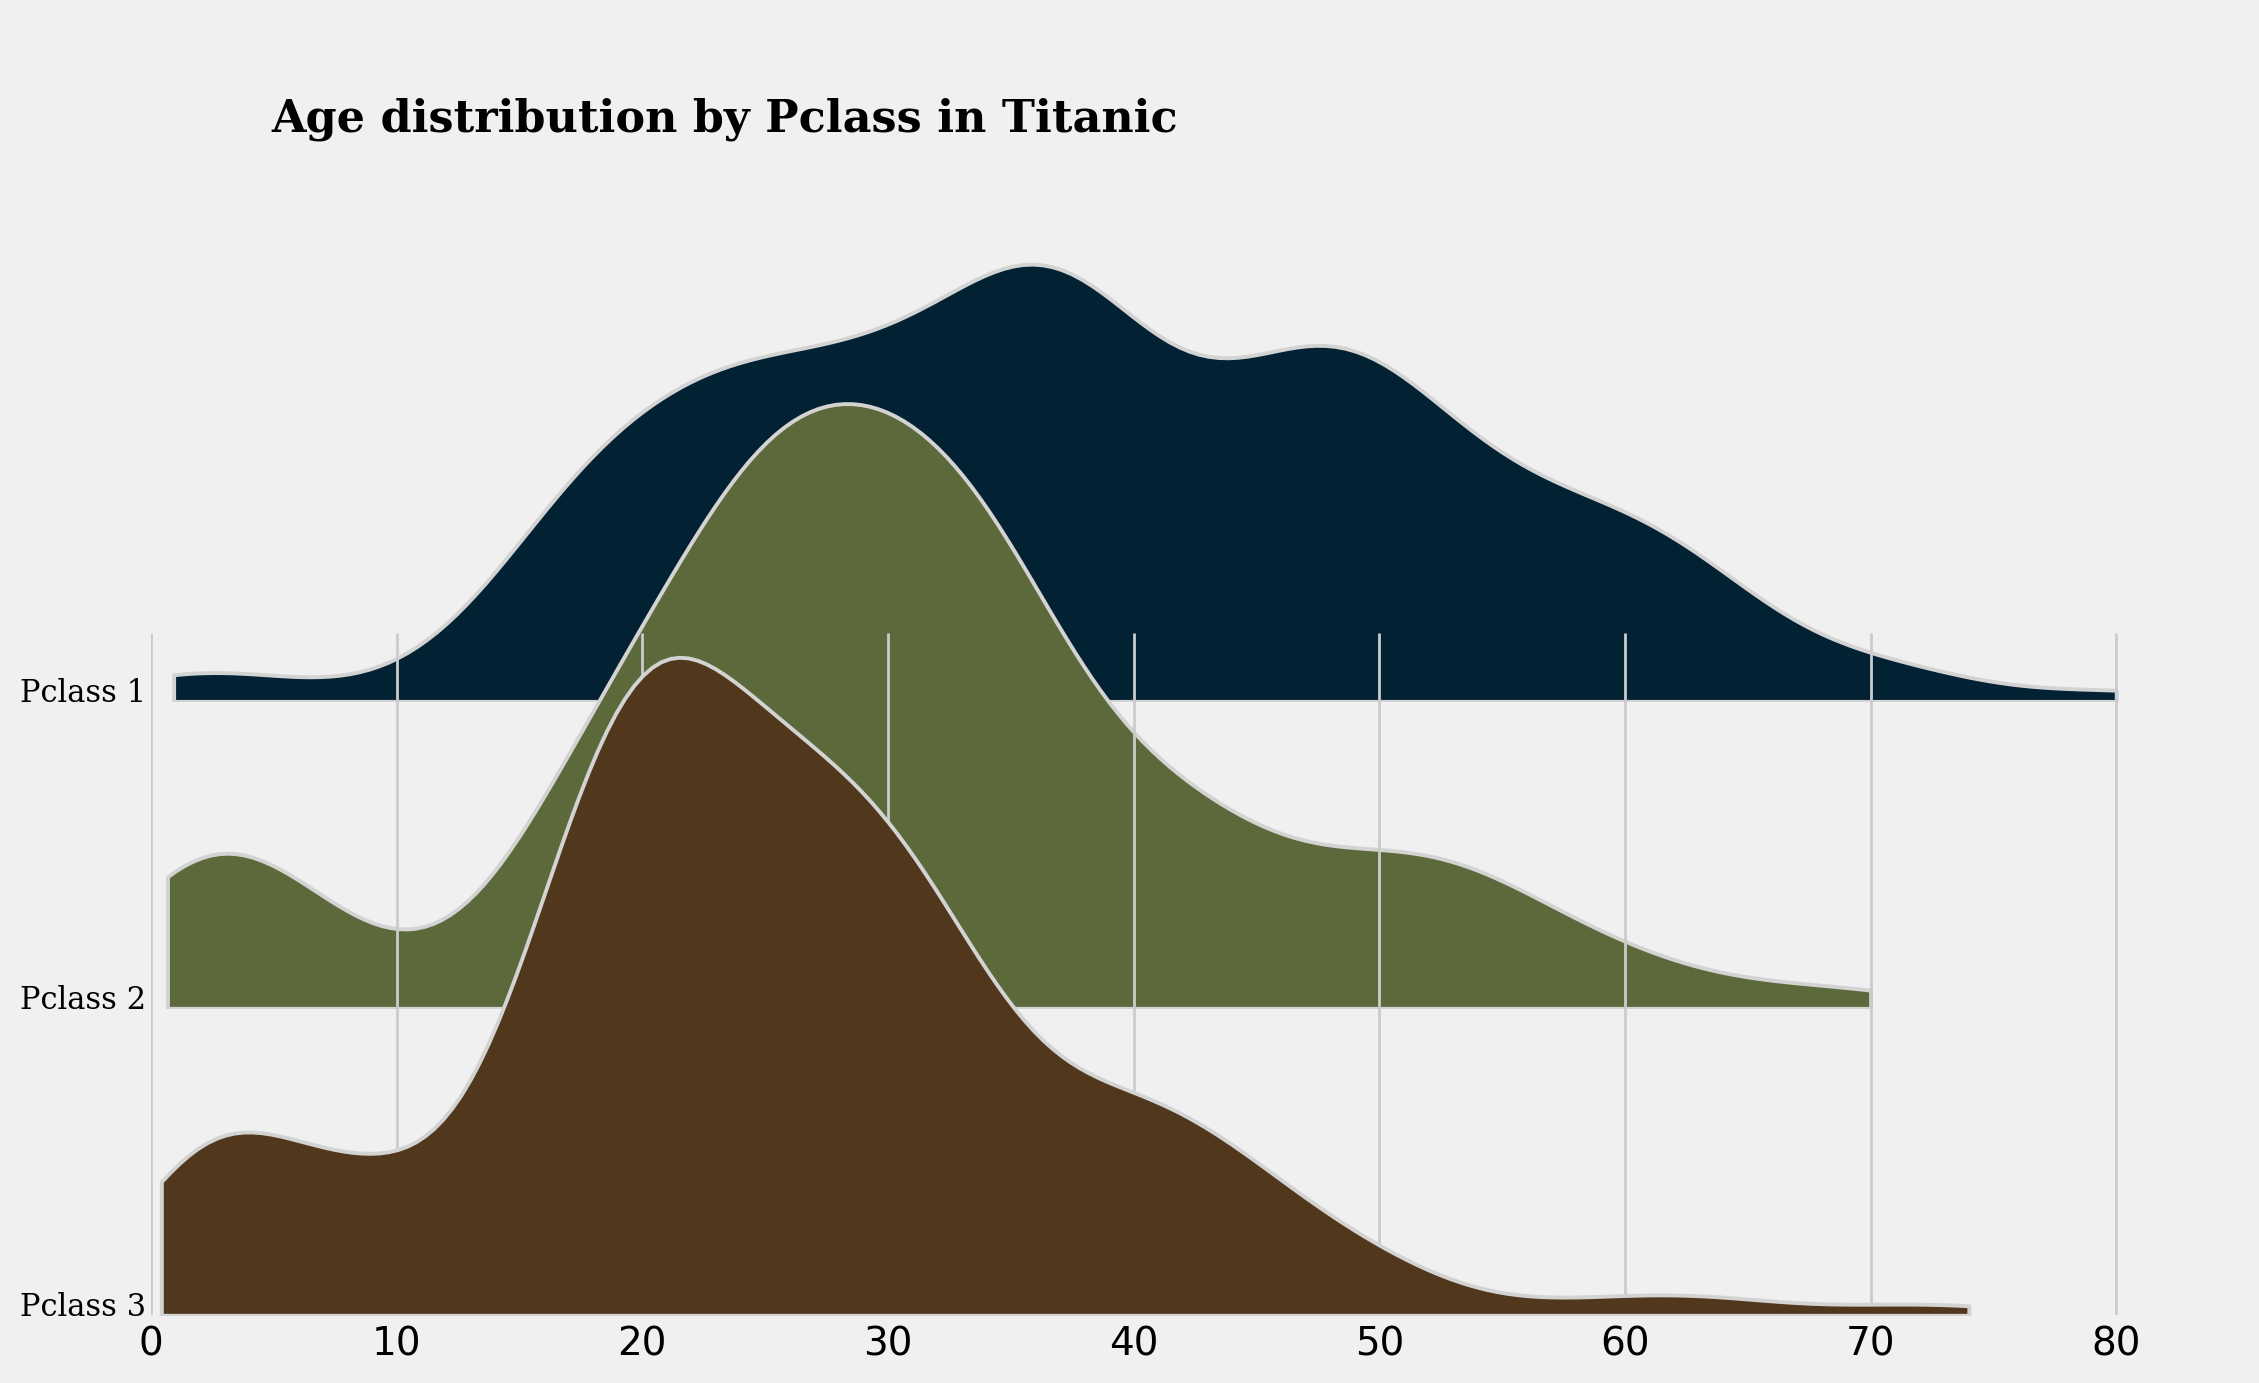

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3,1)
gs.update(hspace= -0.55)

axes = list()
colors = ["#022133", "#5c693b", "#51371c"]

for idx, cls, c in zip(range(3), sorted(ori_train['Pclass'].unique()), colors):
    axes.append(fig.add_subplot(gs[idx, 0]))

    # you can also draw density plot with matplotlib + scipy.
    sns.kdeplot(x='Age', data=ori_train[ori_train['Pclass']==cls],
                fill=True, ax=axes[idx], cut=0, bw_method=0.25,
                lw=1.4, edgecolor='lightgray',color=c, alpha=1)

    axes[idx].set_ylim(0, 0.04)
    axes[idx].set_xlim(0, 85)

    axes[idx].set_yticks([])
    if idx != 2 : axes[idx].set_xticks([])
    axes[idx].set_ylabel('')
    axes[idx].set_xlabel('')

    spines = ["top","right","left","bottom"]
    for s in spines:
        axes[idx].spines[s].set_visible(False)

    axes[idx].patch.set_alpha(0)
    axes[idx].text(-0.2,0,f'Pclass {cls}',fontweight="light", fontfamily='serif', fontsize=11,ha="right")

fig.text(0.13,0.81,"Age distribution by Pclass in Titanic", fontweight="bold", fontfamily='serif', fontsize=16)
plt.show()

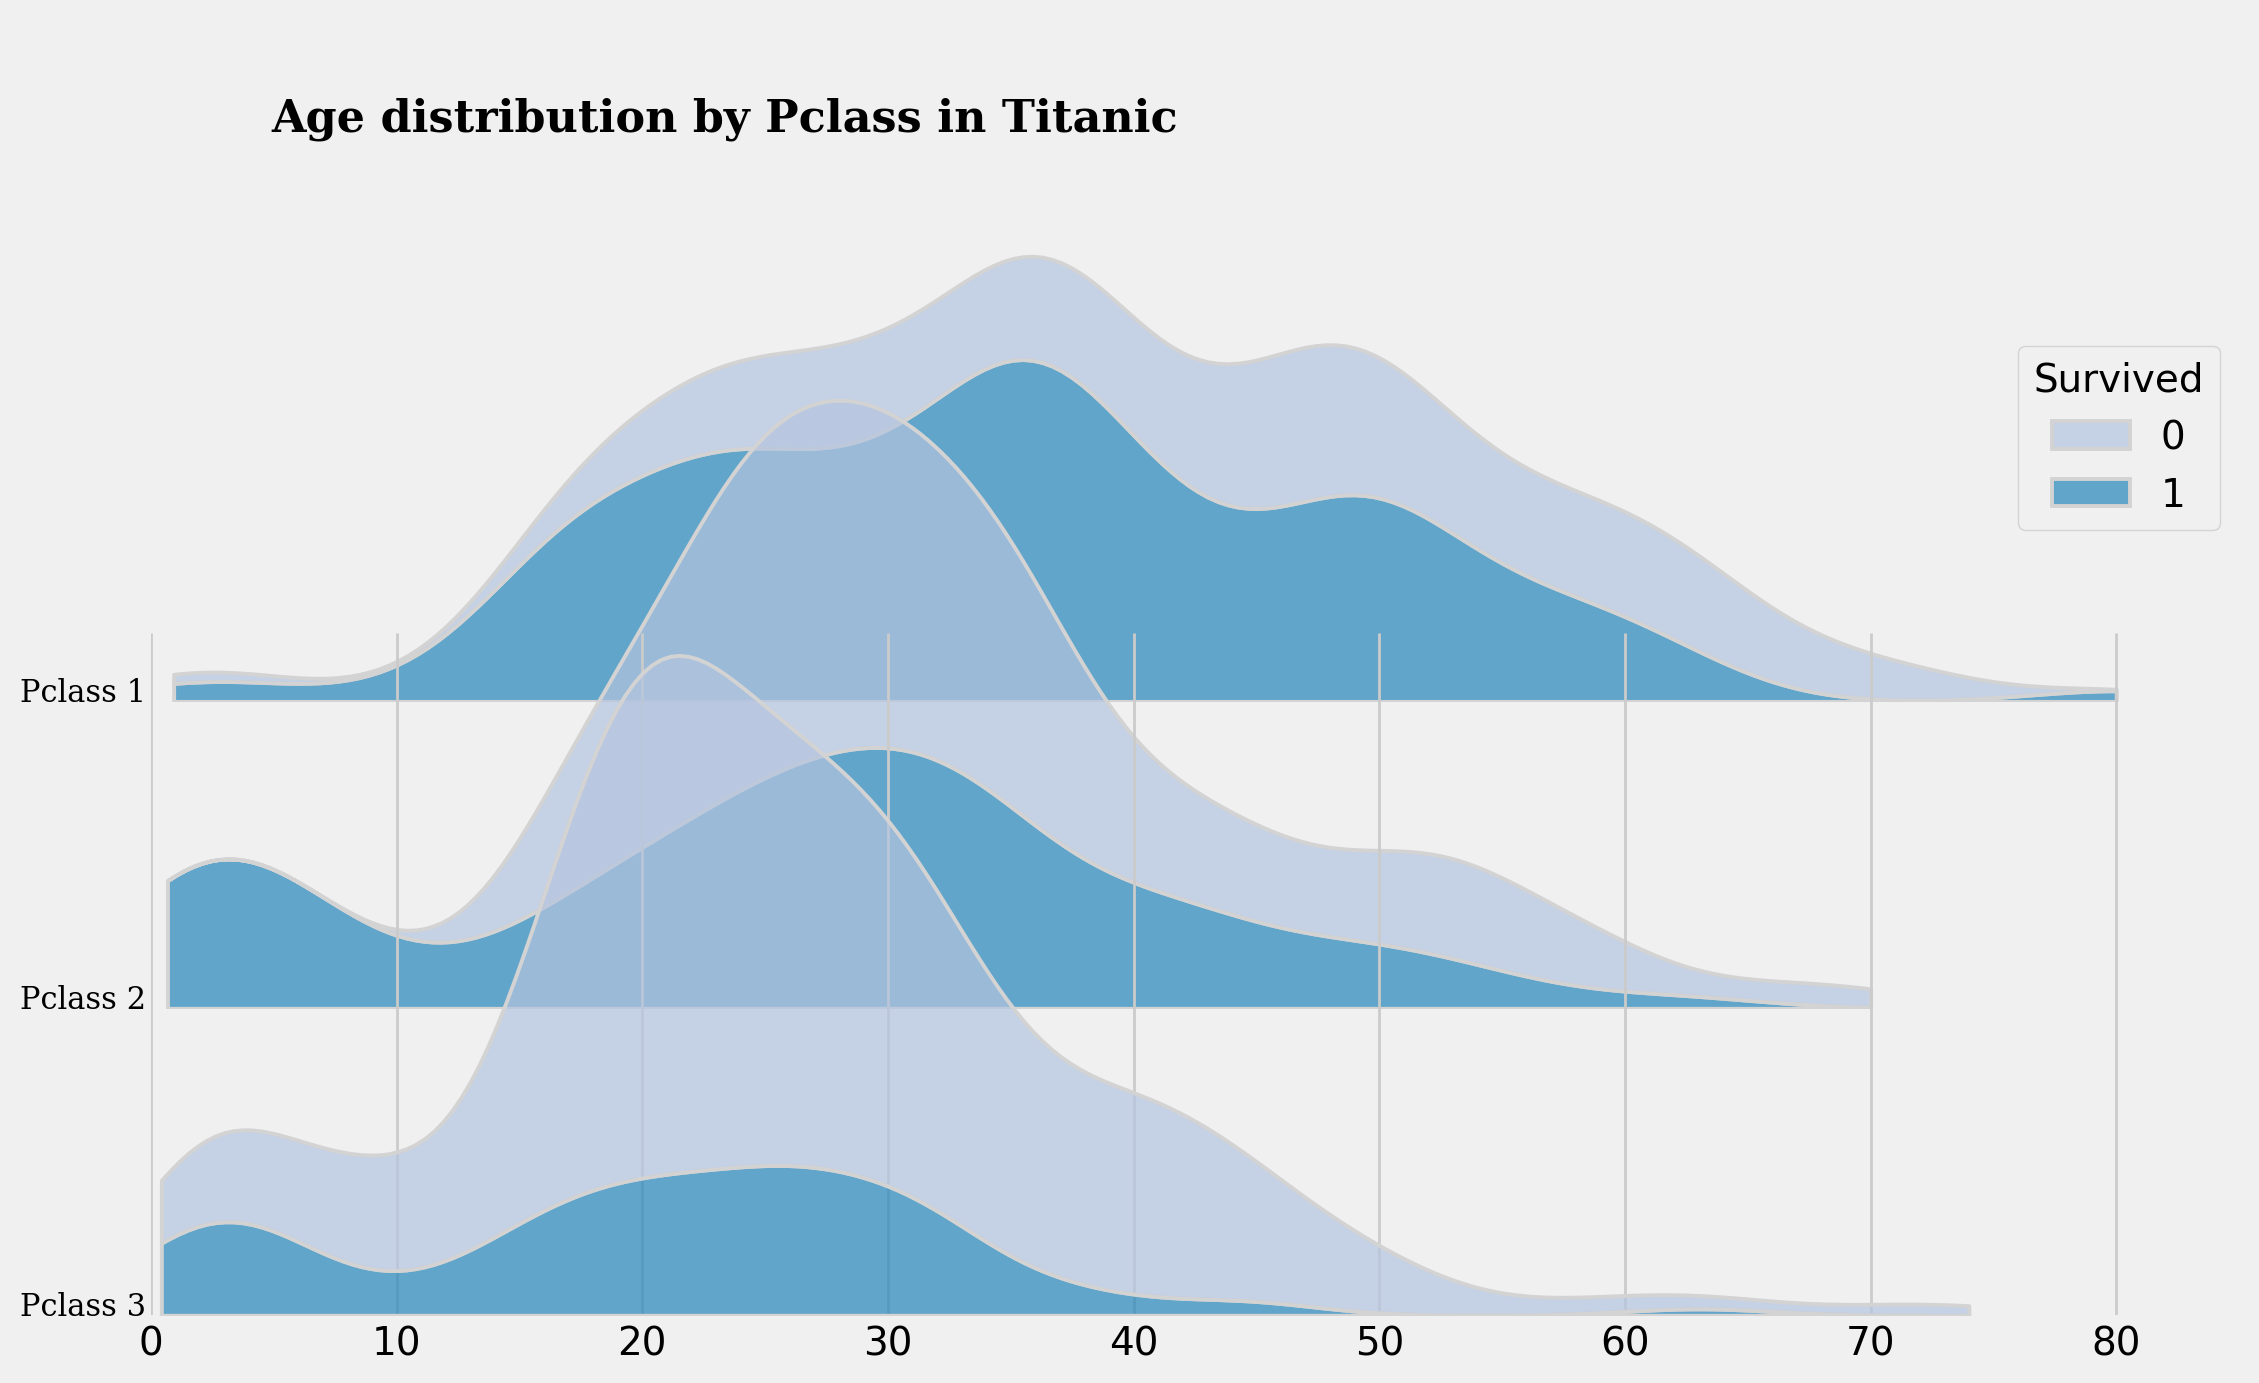

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3,1)
gs.update(hspace= -0.55)

axes = list()
colors = ["#022133", "#5c693b", "#51371c"]

for idx, cls, c in zip(range(3), sorted(ori_train['Pclass'].unique()), colors):
    axes.append(fig.add_subplot(gs[idx, 0]))

    # you can also draw density plot with matplotlib + scipy.
    sns.kdeplot(x='Age', data=ori_train[ori_train['Pclass']==cls],
                fill=True, ax=axes[idx], cut=0, bw_method=0.25,
                lw=1.4, edgecolor='lightgray', hue='Survived',
                multiple="stack", palette='PuBu', alpha=0.7
               )

    axes[idx].set_ylim(0, 0.04)
    axes[idx].set_xlim(0, 85)

    axes[idx].set_yticks([])
    if idx != 2 : axes[idx].set_xticks([])
    axes[idx].set_ylabel('')
    axes[idx].set_xlabel('')

    spines = ["top","right","left","bottom"]
    for s in spines:
        axes[idx].spines[s].set_visible(False)

    axes[idx].patch.set_alpha(0)
    axes[idx].text(-0.2,0,f'Pclass {cls}',fontweight="light", fontfamily='serif', fontsize=11,ha="right")
    if idx != 1 : axes[idx].get_legend().remove()

fig.text(0.13,0.81,"Age distribution by Pclass in Titanic", fontweight="bold", fontfamily='serif', fontsize=16)

plt.show()

PClass는 유의해보이므로, 검정해도 좋아보입니다. (클래스가 높아질수록 살아남을 확률이 높아 보입니다.)

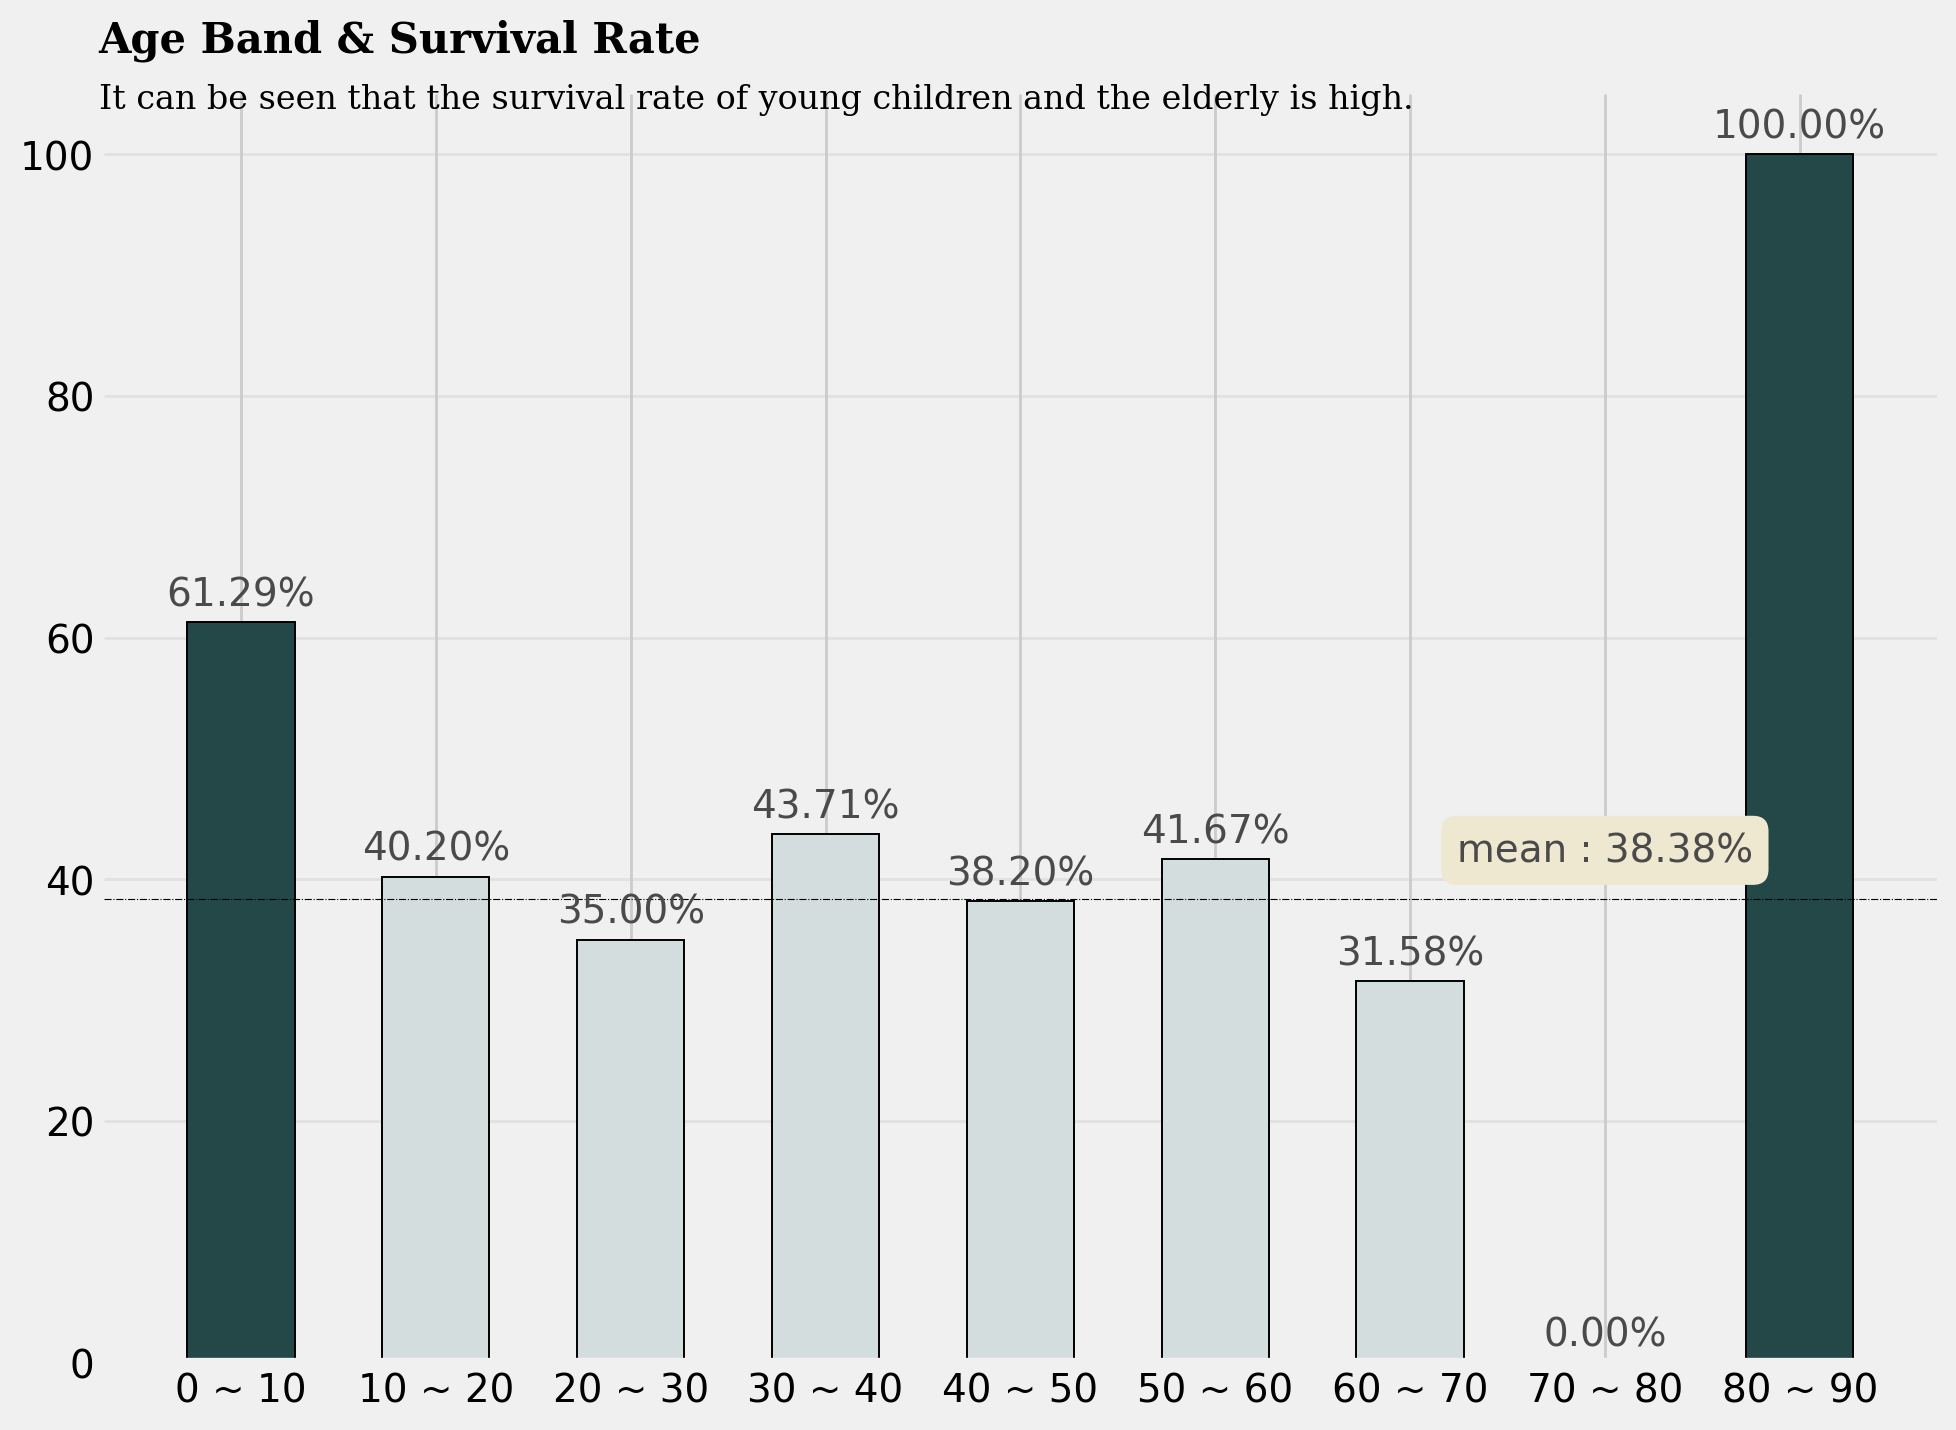

In [ ]:
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

ori_train['age_band'] = ori_train['Age'].apply(age_band)
titanic_age = ori_train[['age_band', 'Survived']].groupby('age_band')['Survived'].value_counts().sort_index().unstack().fillna(0)
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

color_map = ['#d4dddd' for _ in range(9)]
color_map[0] = color_map[8] = '#244747' # color highlight

ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'],
       color=color_map, width=0.55,
       edgecolor='black',
       linewidth=0.7)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)


# Annotation Part
for i in titanic_age['Survival rate'].index:
    ax.annotate(f"{titanic_age['Survival rate'][i]:.02f}%",
                   xy=(i, titanic_age['Survival rate'][i] + 2.3),
                   va = 'center', ha='center',fontweight='light',
                   color='#4a4a4a')


# mean line + annotation
mean = ori_train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%",
            xy=('70 ~ 80', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))


# Title & Subtitle
fig.text(0.06, 1, 'Age Band & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.06, 0.96, 'It can be seen that the survival rate of young children and the elderly is high.', fontsize=12, fontweight='light', fontfamily='serif')

grid_y_ticks = np.arange(0, 101, 20)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()
plt.show()

나이 또한 유의해보이므로, 검정해도 좋아보입니다.

In [ ]:
survival_rate = ori_train.groupby(['Sex'])['Survived'].mean()
survival_rate

,Survived
Sex,
female,0.742038
male,0.188908


In [ ]:
male_rate = survival_rate.loc['male']
female_rate = survival_rate.loc['female']

male_pos = np.random.uniform(0, male_rate, len(ori_train[(ori_train['Sex']=='male') & (ori_train['Survived']==1)]))
male_neg = np.random.uniform(male_rate, 1, len(ori_train[(ori_train['Sex']=='male') & (ori_train['Survived']==0)]))
female_pos = np.random.uniform(0, female_rate, len(ori_train[(ori_train['Sex']=='female') & (ori_train['Survived']==1)]))
female_neg = np.random.uniform(female_rate, 1, len(ori_train[(ori_train['Sex']=='female') & (ori_train['Survived']==0)]))

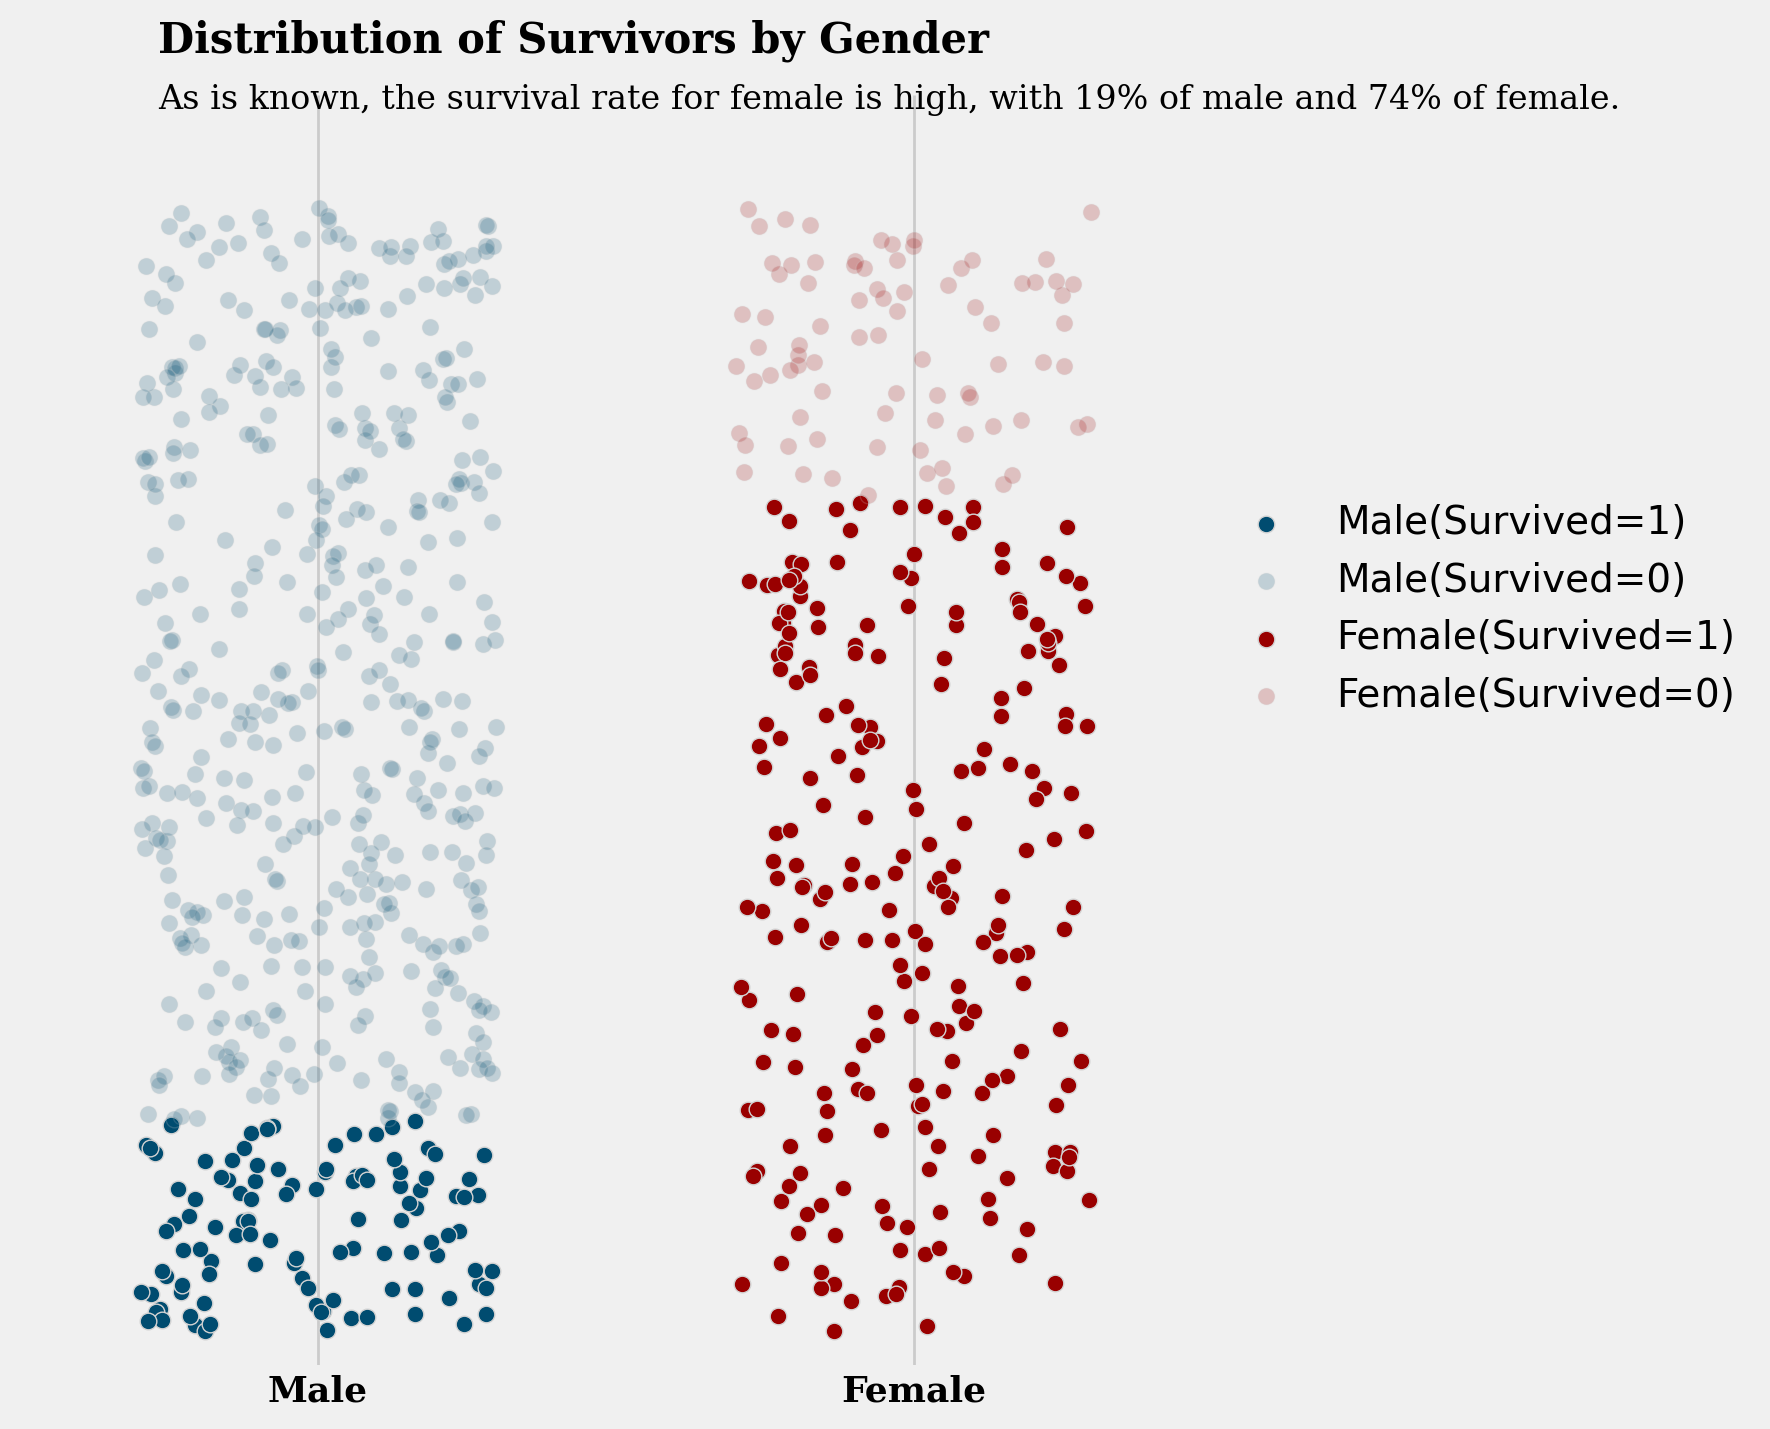

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

np.random.seed(42)

# Male Stripplot
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_pos)), male_pos, color='#004c70', edgecolor='lightgray', label='Male(Survived=1)')
ax.scatter(np.random.uniform(-0.3, 0.3, len(male_neg)), male_neg, color='#004c70', edgecolor='lightgray', alpha=0.2, label='Male(Survived=0)')

# Female Stripplot
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_pos)), female_pos, color='#990000', edgecolor='lightgray', label='Female(Survived=1)')
ax.scatter(1+np.random.uniform(-0.3, 0.3, len(female_neg)), female_neg, color='#990000', edgecolor='lightgray', alpha=0.2, label='Female(Survived=0)')

# Set Figure & Axes
ax.set_xlim(-0.5, 2.0)
ax.set_ylim(-0.03, 1.1)

# Ticks
ax.set_xticks([0, 1])
ax.set_xticklabels(['Male', 'Female'], fontweight='bold', fontfamily='serif', fontsize=13)
ax.set_yticks([], minor=False)
ax.set_ylabel('')

# Spines
for s in ["top","right","left", 'bottom']:
    ax.spines[s].set_visible(False)


# Title & Explanation
fig.text(0.1, 1, 'Distribution of Survivors by Gender', fontweight='bold', fontfamily='serif', fontsize=15)
fig.text(0.1, 0.96, 'As is known, the survival rate for female is high, with 19% of male and 74% of female.', fontweight='light', fontfamily='serif', fontsize=12)

ax.legend(loc=(0.8, 0.5), edgecolor='None')
plt.tight_layout()
plt.show()


성별은 유의해보이므로 검정해도 좋아보입니다.

SibSp, Parch, Fare을 포함한 값들에 대해서도 EDA를 진행하고, 가설 검정의 가치가 있는지를 파악하면 좋습니다.
통계적 검증 방법론을 사용하여 숫자로만 보는 것이 항상 옳지는 않습니다.

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

# 통계적 검증에 대하여

가장 많이 사용하시는 corr() 메소드, 즉 피어슨 상관계수입니다.
그러나 피어슨 상관계수가 모든 데이터에 효과적이진 않습니다.

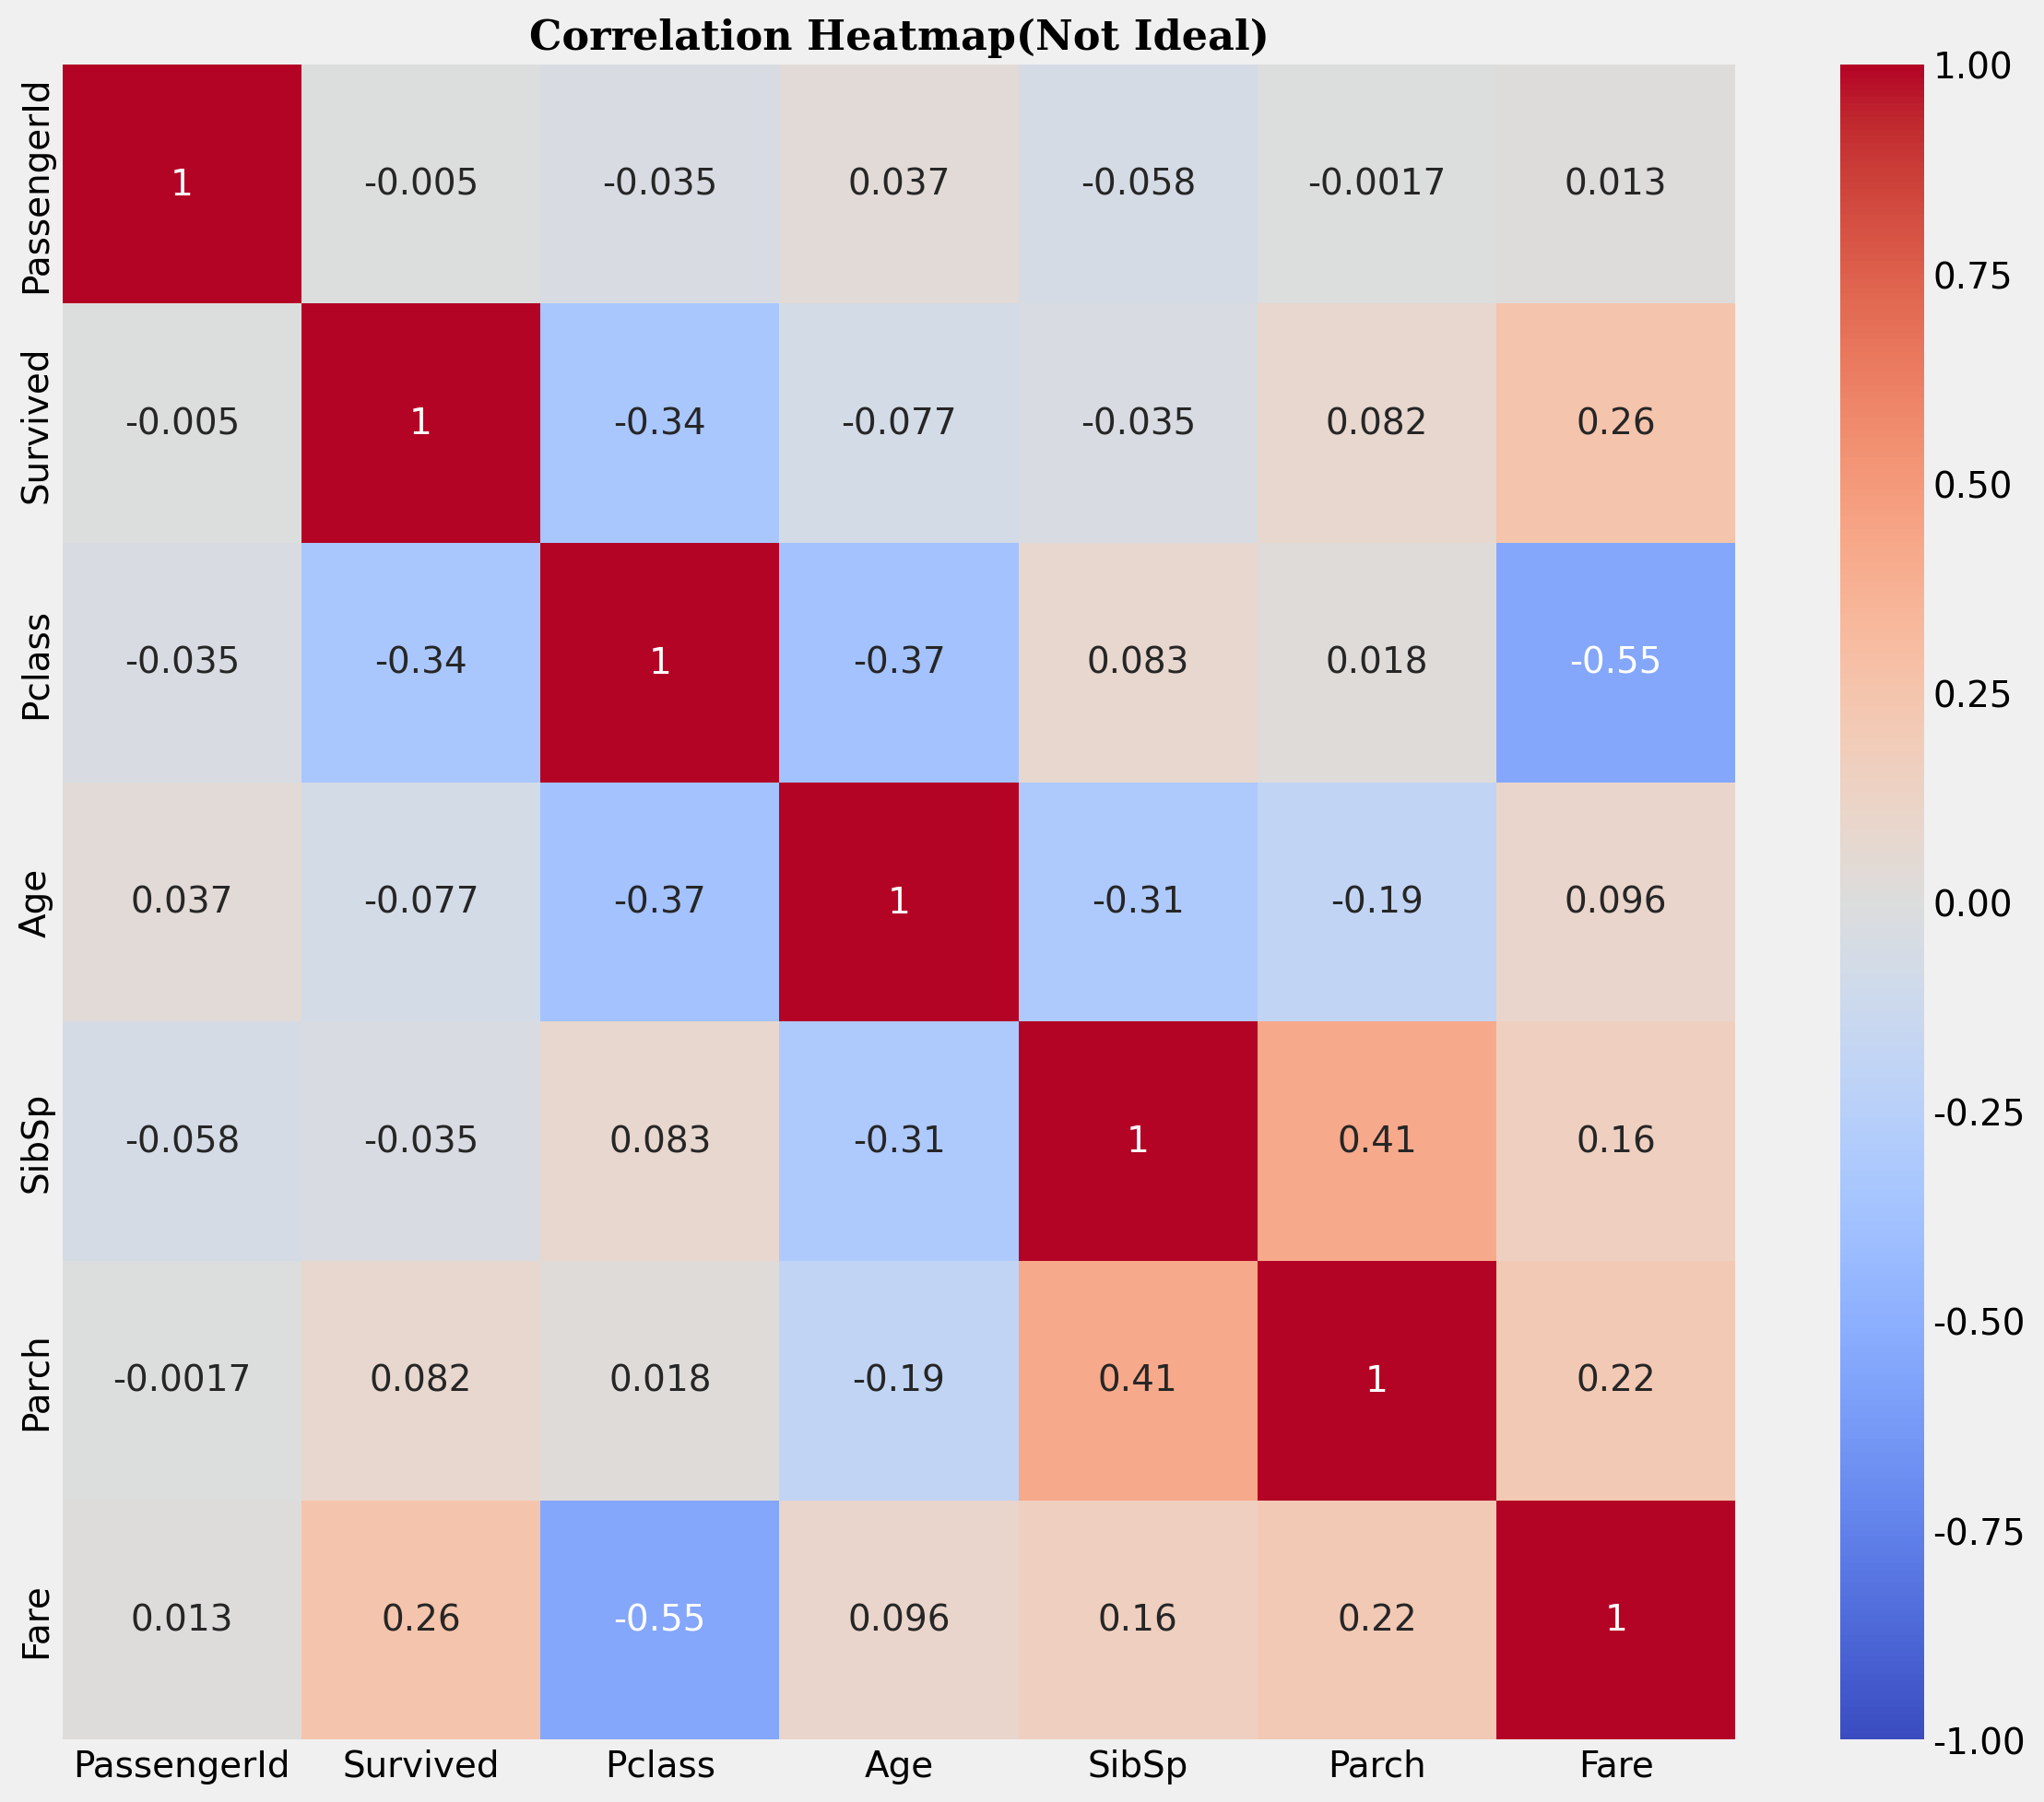

In [ ]:
numeric_train = ori_train.select_dtypes(include=[np.number])
# Figure와 Axes 생성
fig, ax = plt.subplots(figsize=(12, 10))  # Figure 크기 설정

# Heatmap 시각화
sns.heatmap(numeric_train.corr(),
            annot=True,           # 상관계수 값을 셀에 표시
            vmin=-1, vmax=1,      # 색상 범위 설정
            center=0,             # 색상 맵의 중앙값 설정
            cmap='coolwarm',      # 색상 맵 설정
            ax=ax)                # Axes 객체 지정

# 제목 추가
ax.set_title('Correlation Heatmap(Not Ideal)', fontsize=16, fontweight='bold', fontfamily='serif')

# 레이아웃 조정
plt.tight_layout()
plt.show()

위의 결과는 옳지 못합니다.
Survived는 이진값에 가까우므로, 연속형 - 연속형 상관관계에 사용되는 피어슨 상관계수를 이용하여 올바른 값을 도출하기 어렵습니다.데이터의 타입에 맞는 다른 검증 방법을 사용하는 것이 좋습니다.

In [ ]:
ori_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

대표적으로 아래 컬럼들에 대해 검정을 진행해보겠습니다.

### 범주형 변수 - 이진 변수 (Embarked, Sex)

In [ ]:
# 카이제곱 검정 : 범주형 변수와 이진 변수 간의 독립성 테스트
from scipy.stats import chi2_contingency

Embarked_Survived = pd.crosstab(ori_train['Survived'], ori_train['Embarked'])

chi2, p, dof, expected = chi2_contingency(Embarked_Survived)
print(f"Chi-square: {chi2}, p-value: {p}")
#chi-square이 클수록 독립성이 낮아져, 두 변수 간 유의미한 관계가 있을 가능성이 높아짐
#p-value 0.05 이하일 때 통계적으로 유의미하다는 결론

Chi-square: 26.48914983923762, p-value: 1.769922284120912e-06


In [ ]:
Sex_Survived = pd.crosstab(ori_train['Sex'], ori_train['Survived'])

chi2, p, dof, expected = chi2_contingency(Sex_Survived)
print(f"Chi-square: {chi2}, p-value: {p}")

Chi-square: 260.71702016732104, p-value: 1.1973570627755645e-58


두 값으로 미루어볼 때, Sex와 Survived 간의 강한 상관관계를 확인할 수 있습니다.

### 순서 척도 - 이진 변수 (Pclass, SibSp, Parch)

In [ ]:
# Spearman's Rank Correlation 계산
from scipy.stats import spearmanr

correlation, p_value = spearmanr(ori_train['Survived'], ori_train['Pclass'])
print(f"Spearman's Rank Correlation: {correlation:.2f}")
print(f"p-value: {p_value:.4f}")
#우연이 아닌 약한 상관관계를 가지고 있을 가능성

Spearman's Rank Correlation: -0.34
p-value: 0.0000


In [ ]:
#Pclass를 순서 척도가 아닌 범주형 변수로 취급한다면?
Pclass_Survived = pd.crosstab(ori_train['Pclass'], ori_train['Survived'])

chi2, p, dof, expected = chi2_contingency(Pclass_Survived)
print(f"Chi-square: {chi2}, p-value: {p}")
#Pclass의 값이 생존 확률에 영향을 미친다.

Chi-square: 102.88898875696056, p-value: 4.549251711298793e-23


### 연속형 변수 - 이진 변수 (Age, Fare)

In [ ]:
#Age에 결측치 값이 있었으므로, 결측값 row를 제외하여 따로 샘플을 만들었습니다.
sample_train = ori_train.copy()

In [ ]:
sample_train = sample_train.dropna(subset=['Age'])

In [ ]:
sample_train = sample_train[['Age', 'Survived']]

In [ ]:
# 점-이분 상관계수 (One scale naturally dichotomous(nominal), one scale interval or ratio)
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(sample_train['Survived'], sample_train['Age'])
print(f"Point-Biserial Correlation: {corr:.2f}")
print(f"p-value: {p_value:.4f}")
#거의 관계가 없으며, 유의하지 않다고 결과가 나왔습니다.

Point-Biserial Correlation: -0.08
p-value: 0.0391


그런데 나이가 적다고 많이 살고, 나이가 많다고 적게 산 건 아니었습니다. 오히려 어린 연령대와 나이 많은 연령대의 생존율이 높았으니까요. 이렇게 판단하면 안될 것 같습니다.
이렇게 수치형 변수가 비선형적인 경우는 어떻게 할까요? 팀원과 고민해보세요.

이런 검정을 통해 모델의 성능에 좋지 않은 영향을 끼치며, 과적합 확률을 높이는 피쳐들을 제외하도록 합니다.

# 피쳐

## 결측치 처리

In [ ]:
input_train = ori_train.drop(['PassengerId', 'Cabin'], axis=1)

In [ ]:
#사용할 것 중에서는 Embarked와 Age의 결측치만이 있네요.
input_train.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Embarked,2


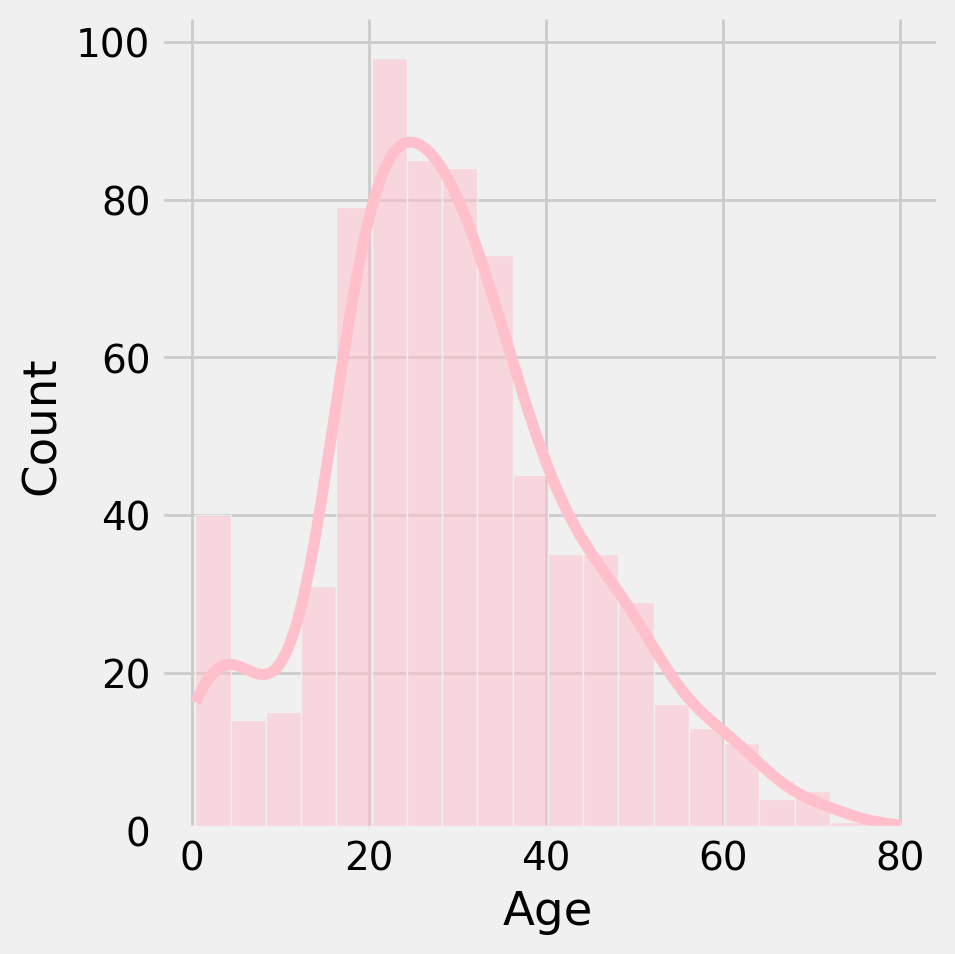

In [ ]:
#Mean or Median? 데이터 분포를 확인해 결정하기!
sns.displot(input_train['Age'], kde=True, color='pink') #핑크색 예쁘죵
plt.show()

데이터 분포가 정규분포의 모양에서 크게 벗어나 왜곡되거나 쏠리지는 않았습니다.

In [ ]:
# 연속형 변수 선택
continuous_vars = ['Pclass', 'SibSp', 'Parch', 'Fare']

# Age와 연속형 변수들의 상관계수 계산
correlation_matrix = input_train[continuous_vars + ['Age']].corr()
print(correlation_matrix['Age'].sort_values(ascending=False))


Age       1.000000
Fare      0.096067
Parch    -0.189119
SibSp    -0.308247
Pclass   -0.369226
Name: Age, dtype: float64


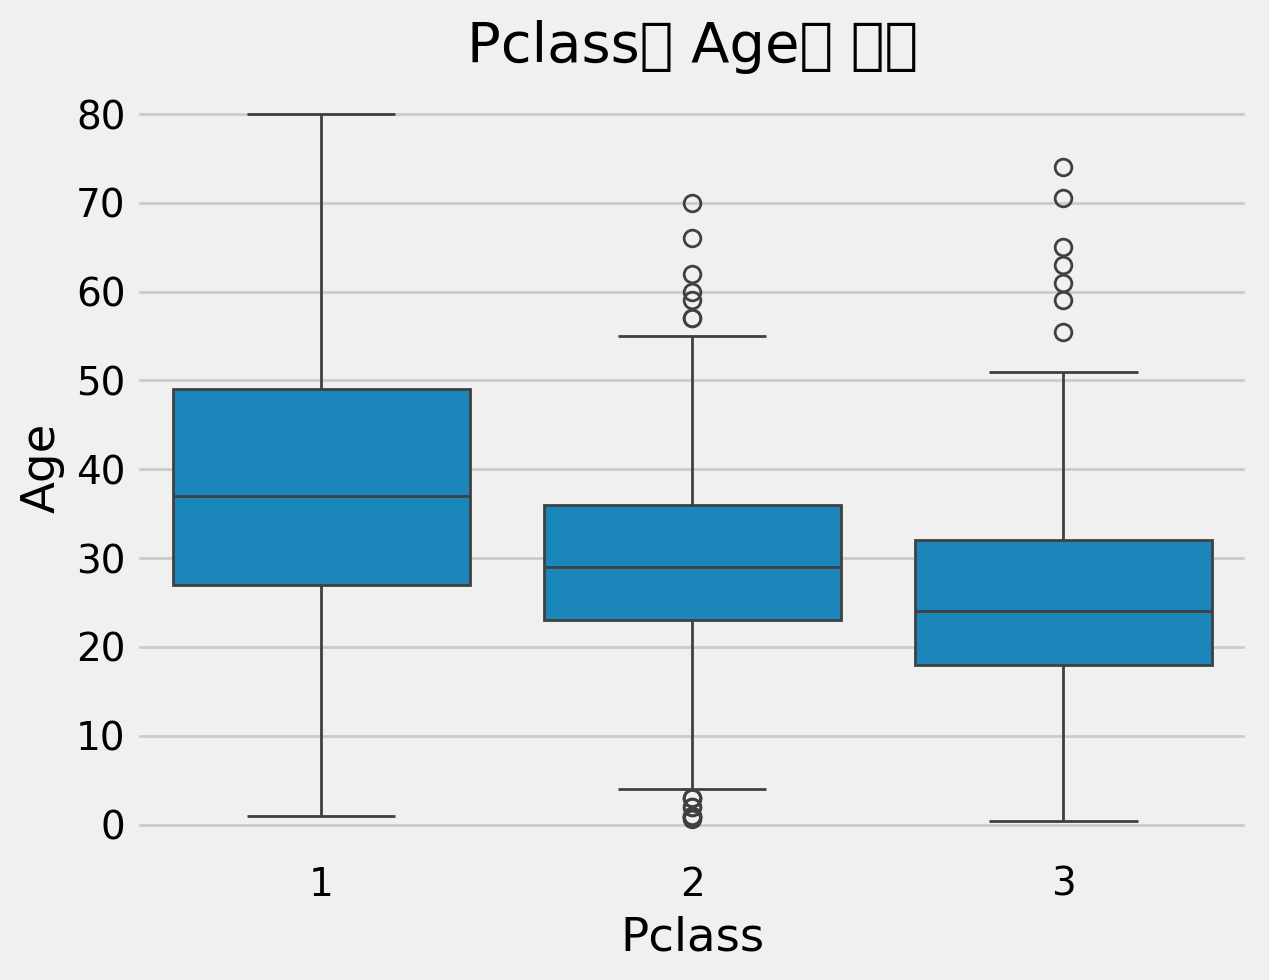

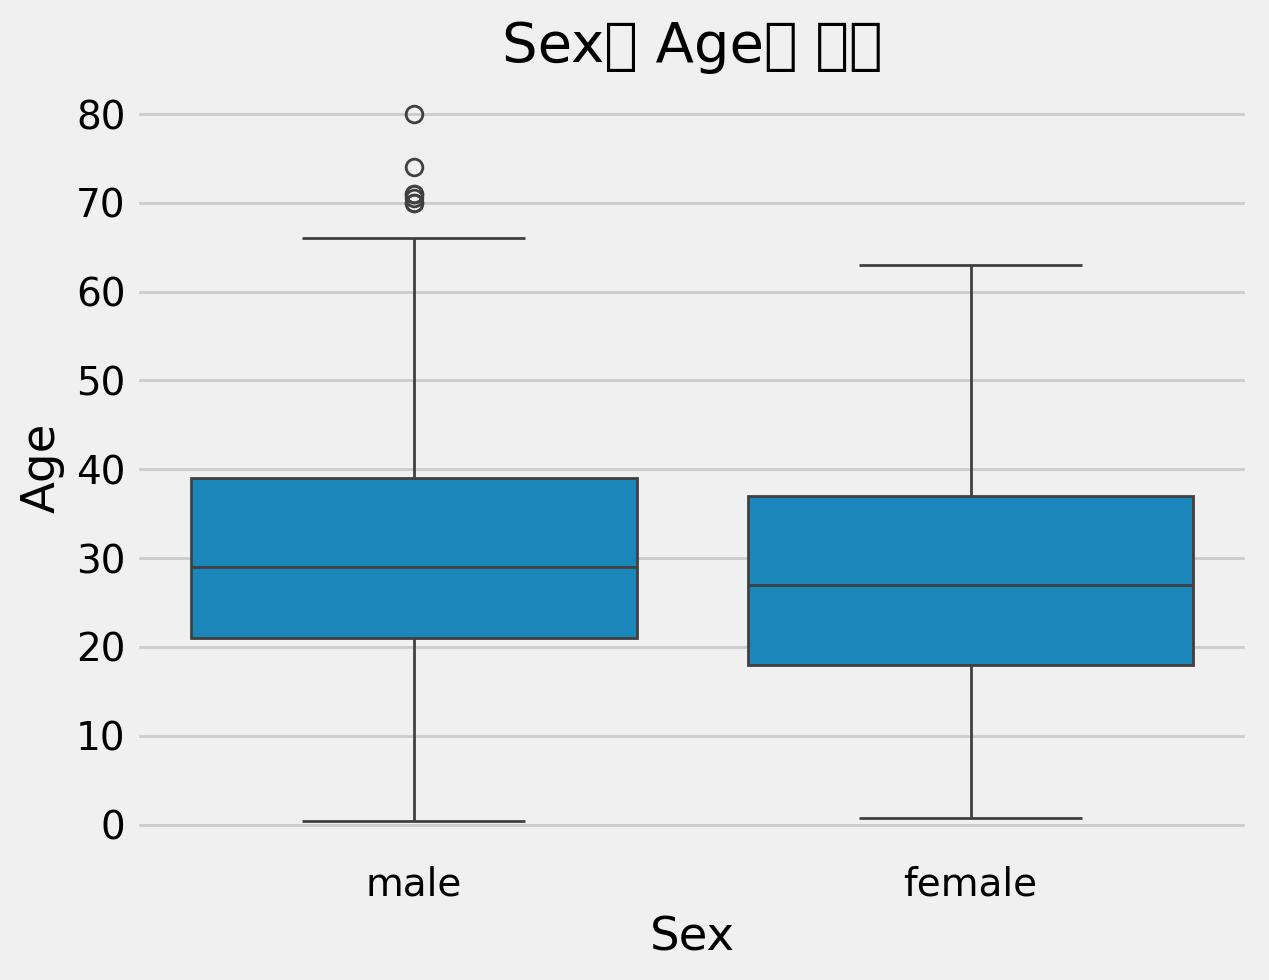

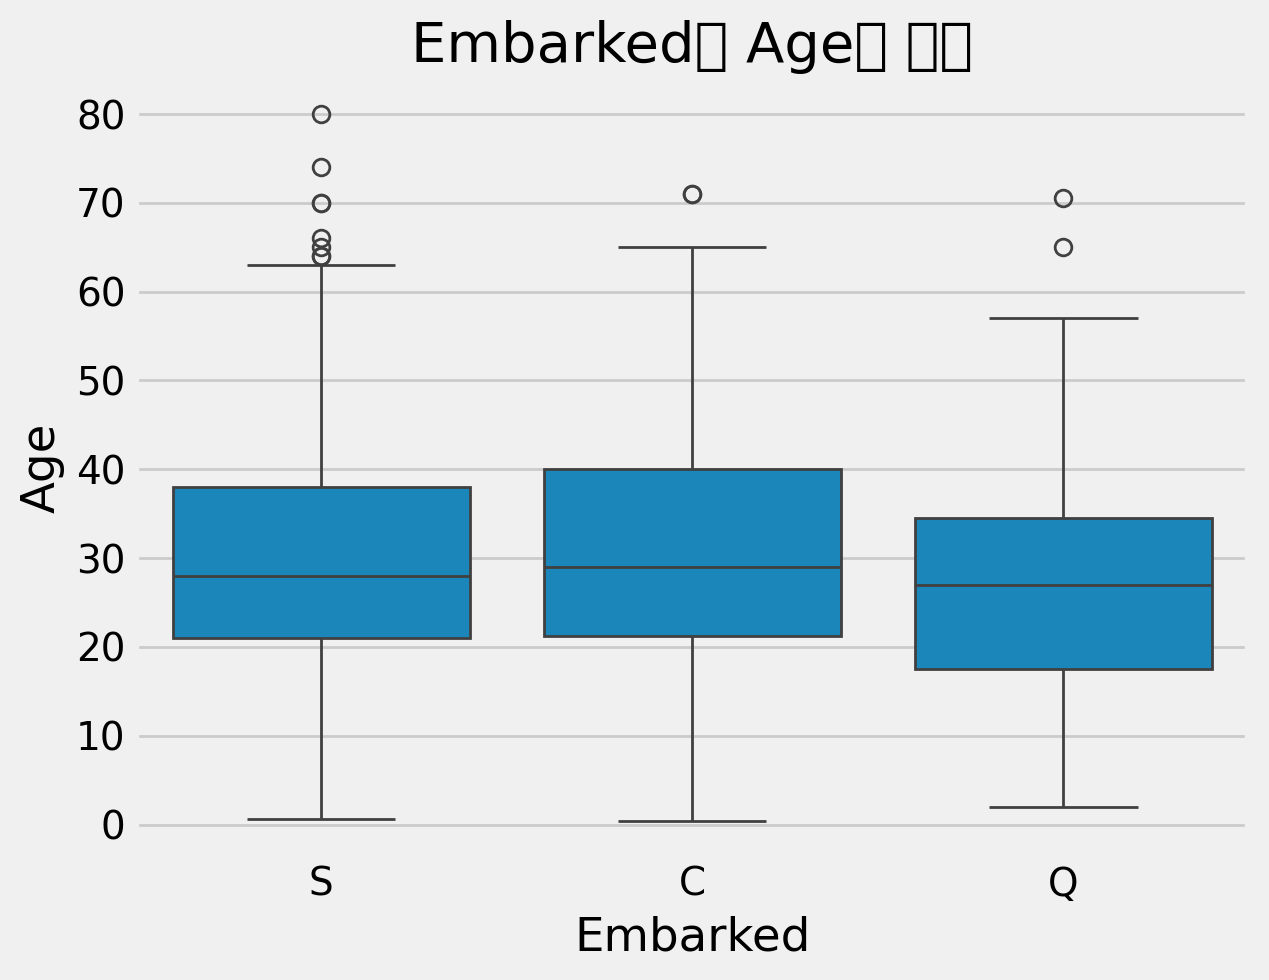

In [ ]:
# Pclass별 Age 분포 시각화
sns.boxplot(x='Pclass', y='Age', data=input_train)
plt.title('Pclass와 Age의 관계')
plt.show()

# 성별에 따른 Age 분포 시각화
sns.boxplot(x='Sex', y='Age', data=input_train)
plt.title('Sex와 Age의 관계')
plt.show()

# Embarked별 Age 분포 시각화
sns.boxplot(x='Embarked', y='Age', data=input_train)
plt.title('Embarked와 Age의 관계')
plt.show()


In [ ]:
# Pclass별 Age의 중앙값 계산
age_median_by_pclass = input_train.groupby('Pclass')['Age'].median()

# 결측치 채우기
input_train['Age'] = input_train.apply(lambda row: age_median_by_pclass[row['Pclass']] if pd.isnull(row['Age']) else row['Age'], axis=1)


 Pclass별 Age의 중앙값으로 결측치 채움

In [ ]:
input_train['Embarked'].fillna(input_train['Embarked'].mode()[0], inplace=True)

Embarked는 범주형 변수이므로 Mode(최빈값)으로 결측치를 보완했습니다.

## 인코딩


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# ✅ Pclass, Sex → Label Encoding
label_encoders = {}  # LabelEncoder 저장용
for col in ['Pclass', 'Sex']:
    le = LabelEncoder()
    input_train[col] = le.fit_transform(input_train[col])
    label_encoders[col] = le  # 나중에 역변환할 수도 있음

# ✅ Embarked → One-Hot Encoding
input_train = pd.get_dummies(input_train, columns=['Embarked'], prefix='Embarked')

# 결과 확인
input_train.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,2,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,False,False,True
1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,True,False,False
2,1,2,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,False,False,True
3,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,False,False,True
4,0,2,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,False,False,True


## 이상치 판단

### age

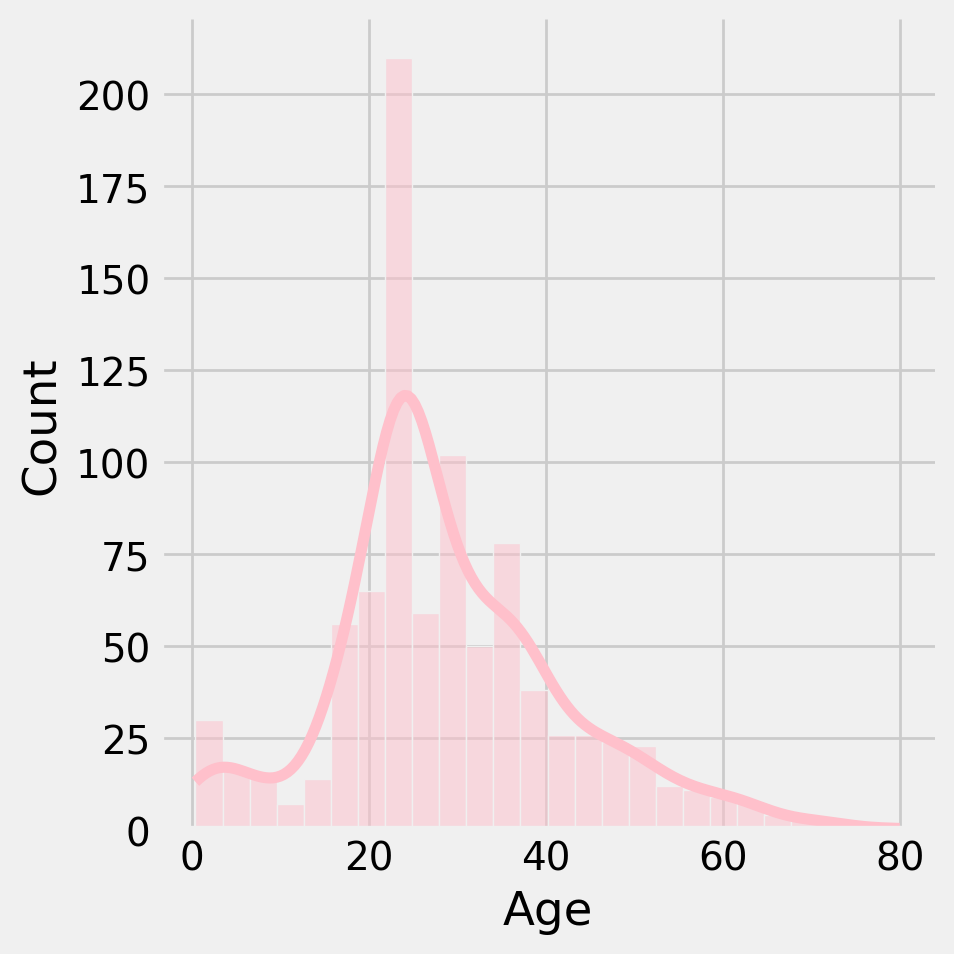

In [ ]:
sns.displot(input_train['Age'], kde=True, color='pink') #핑크색 예쁘죵
plt.show()

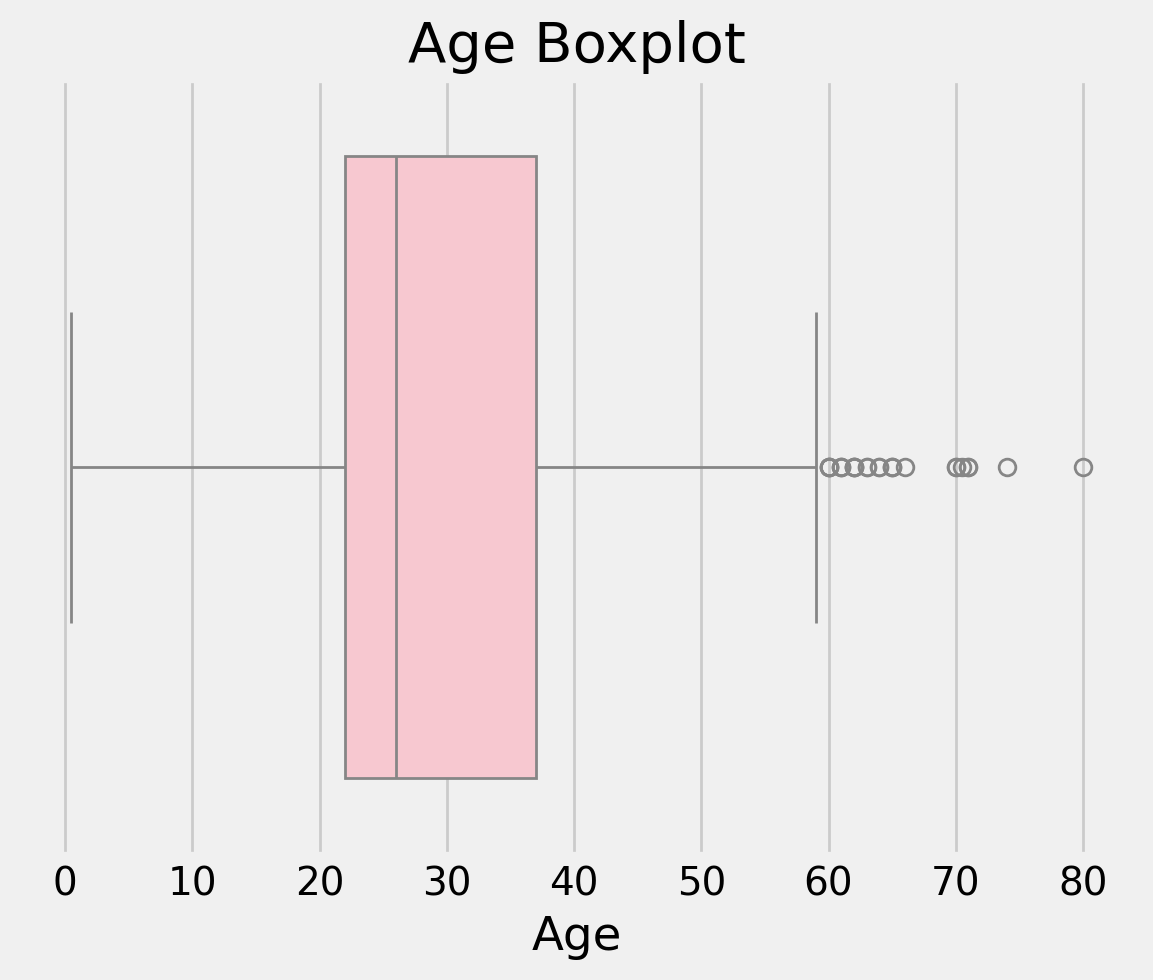

In [ ]:
sns.boxplot(x=input_train['Age'], color='pink')
plt.title('Age Boxplot')
plt.show()

In [ ]:
from scipy import stats

z_scores = stats.zscore(input_train['Age'])
abs_z_scores = np.abs(z_scores)
age_threshold = 3
age_outliers = input_train[abs_z_scores > age_threshold]

print("Age 이상치 (Z-score 기준):")
print(age_outliers)

Age 이상치 (Z-score 기준):
     Survived  Pclass                                  Name  Sex   Age  SibSp  \
96          0       0             Goldschmidt, Mr. George B    1  71.0      0   
116         0       2                  Connors, Mr. Patrick    1  70.5      0   
493         0       0               Artagaveytia, Mr. Ramon    1  71.0      0   
630         1       0  Barkworth, Mr. Algernon Henry Wilson    1  80.0      0   
672         0       1           Mitchell, Mr. Henry Michael    1  70.0      0   
745         0       0          Crosby, Capt. Edward Gifford    1  70.0      1   
851         0       2                   Svensson, Mr. Johan    1  74.0      0   

     Parch      Ticket     Fare  Embarked_C  Embarked_Q  Embarked_S  
96       0    PC 17754  34.6542        True       False       False  
116      0      370369   7.7500       False        True       False  
493      0    PC 17609  49.5042        True       False       False  
630      0       27042  30.0000       False      

In [ ]:
# 이상치 7개 제거
input_train = input_train[abs_z_scores <= age_threshold]

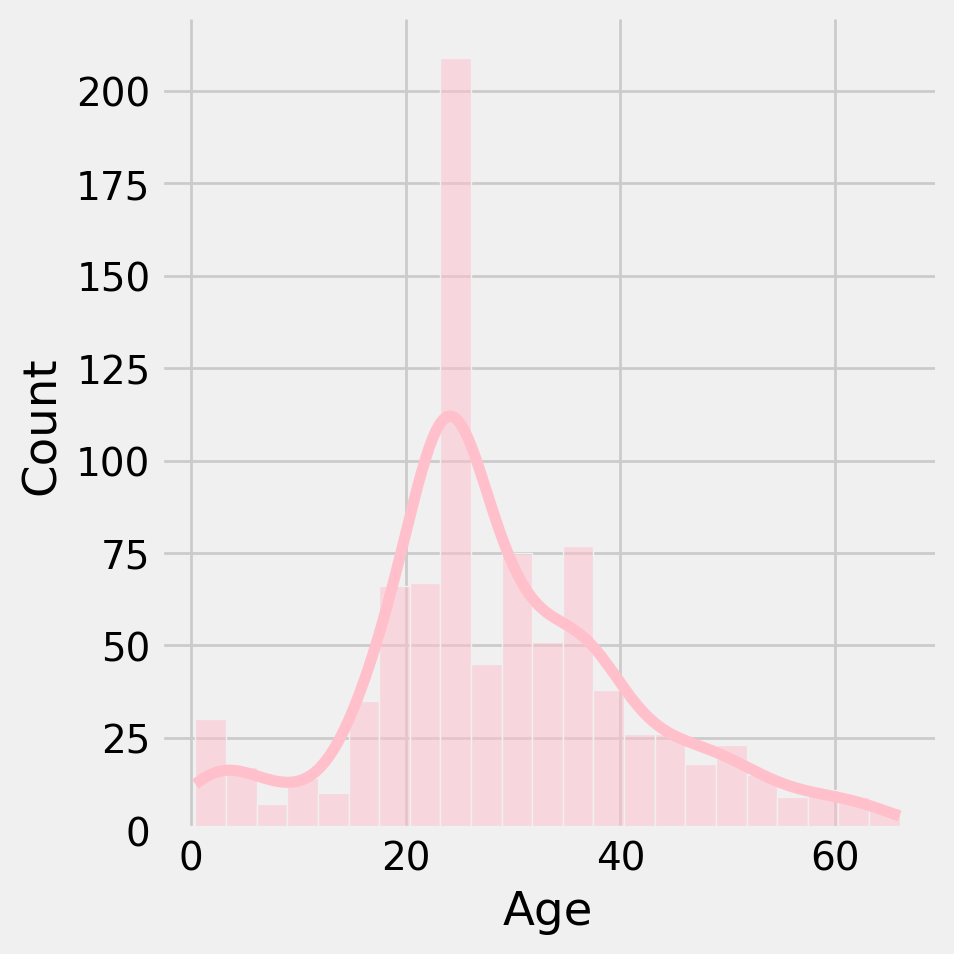

In [ ]:
#이상치 처리 후 모습
sns.displot(input_train['Age'], kde=True, color='pink')
plt.show()

정규분포 모양에 좀 더 가까워짐

### fare

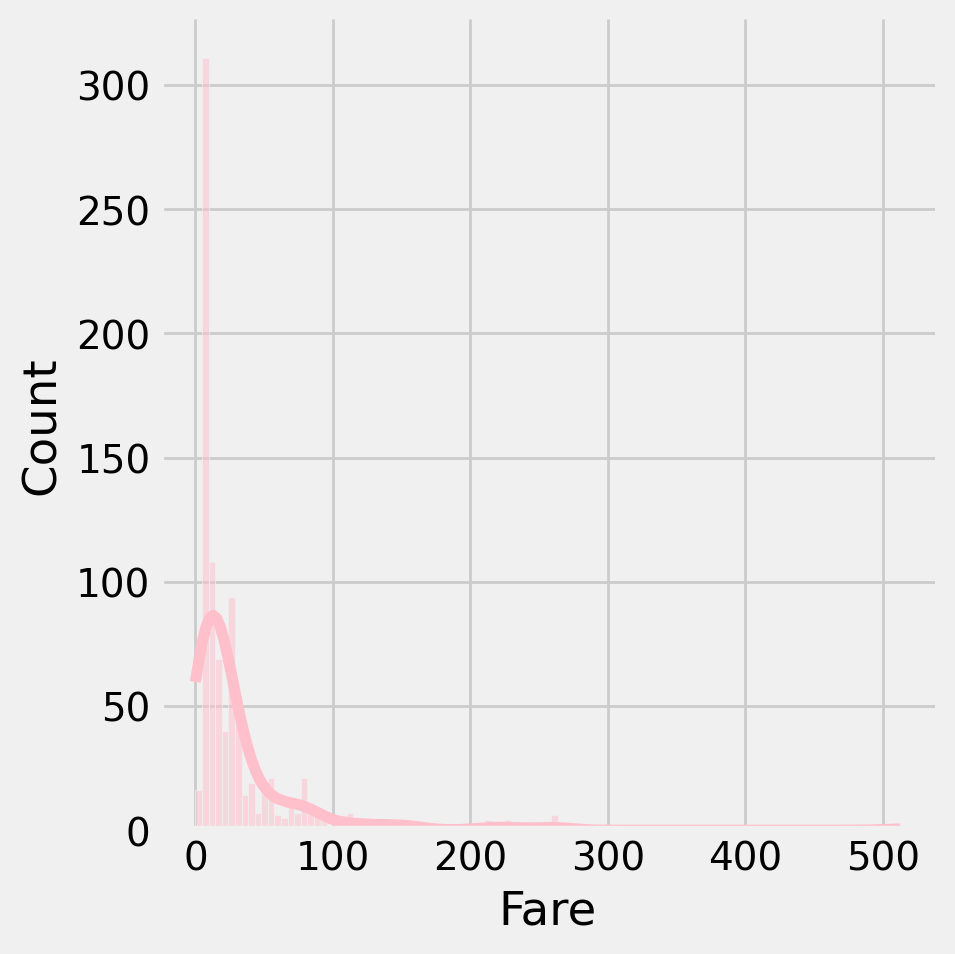

In [ ]:
sns.displot(input_train['Fare'], kde=True, color='pink') #핑크색 예쁘죵
plt.show()

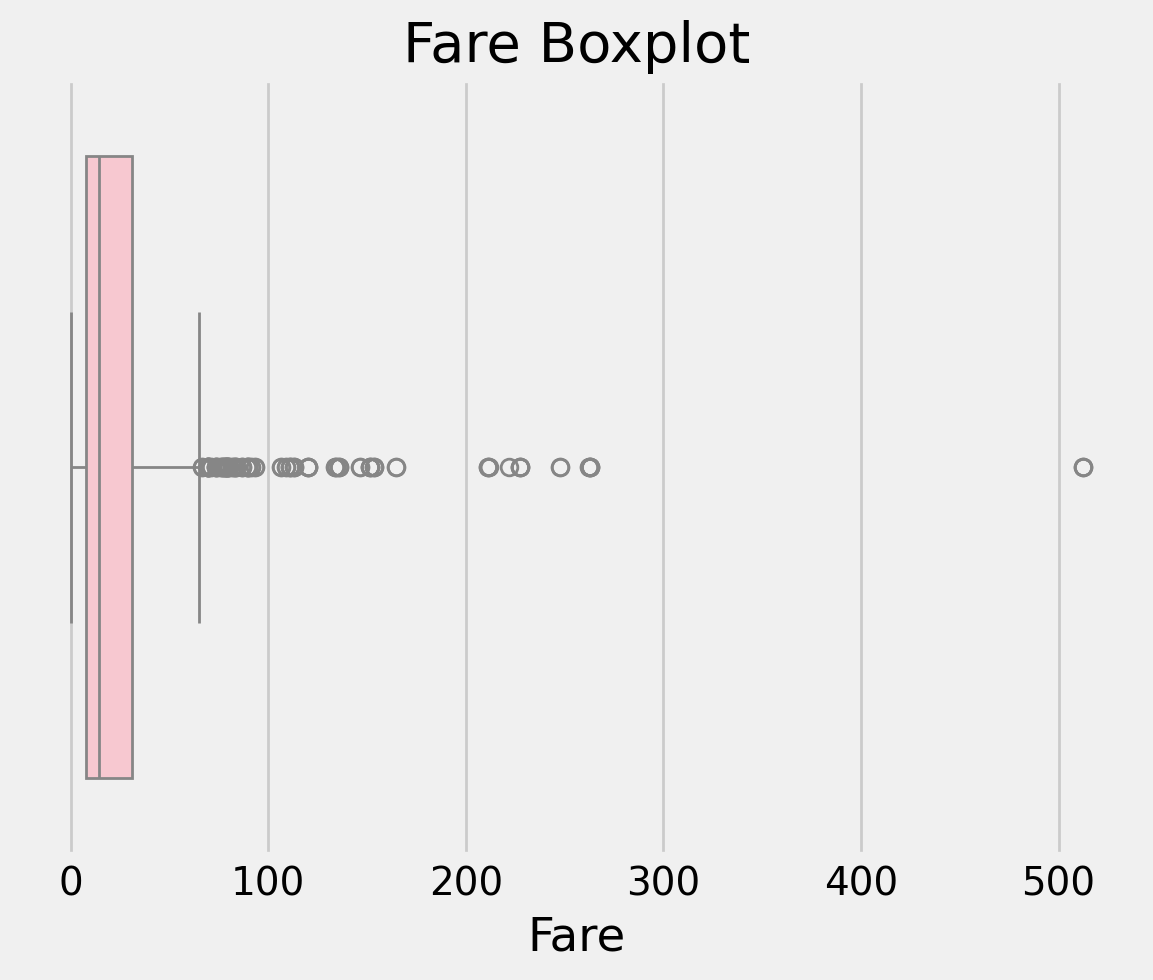

In [ ]:
# IQR을 이용한 이상치 탐지
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_fare = detect_outliers_iqr(input_train, 'Fare')

sns.boxplot(x=input_train['Fare'], color='pink')
plt.title('Fare Boxplot')
plt.show()

In [ ]:
# Fare의 왜도 확인
from scipy.stats import skew

fare_skewness = skew(input_train['Fare'], nan_policy='omit')
print(f"Fare의 왜도: {fare_skewness}")

Fare의 왜도: 4.770584710234935


왜도가 0보다 매우 큰 값으로, 오른쪽 꼬리가 긴 분포. (시각화에서도 이미 확인됨) \
-> 오른쪽 꼬리가 길다면 로그 변환 써봐도 좋을 듯

In [ ]:
# 로그 변환
input_train['Fare_log'] = np.log1p(input_train['Fare'])

input_train[['Fare', 'Fare_log']].describe()

,Fare,Fare_log
count,884.000000,884.000000
mean,32.220323,2.960827
std,49.850483,0.970101
min,0.000000,0.000000
25%,7.917700,2.188037
50%,14.454200,2.737881
75%,31.000000,3.465736
max,512.329200,6.240917


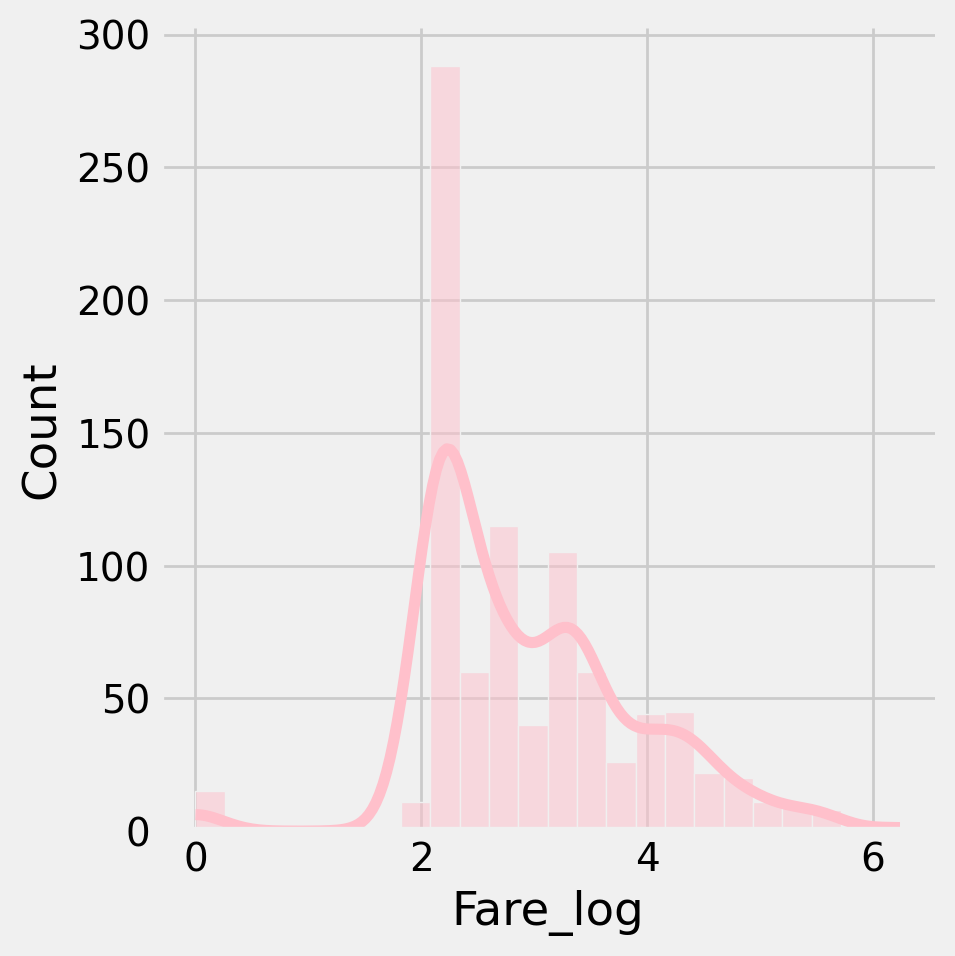

In [ ]:
sns.displot(input_train['Fare_log'], kde=True, color='pink')
plt.show()

여전히 비대칭적 분포

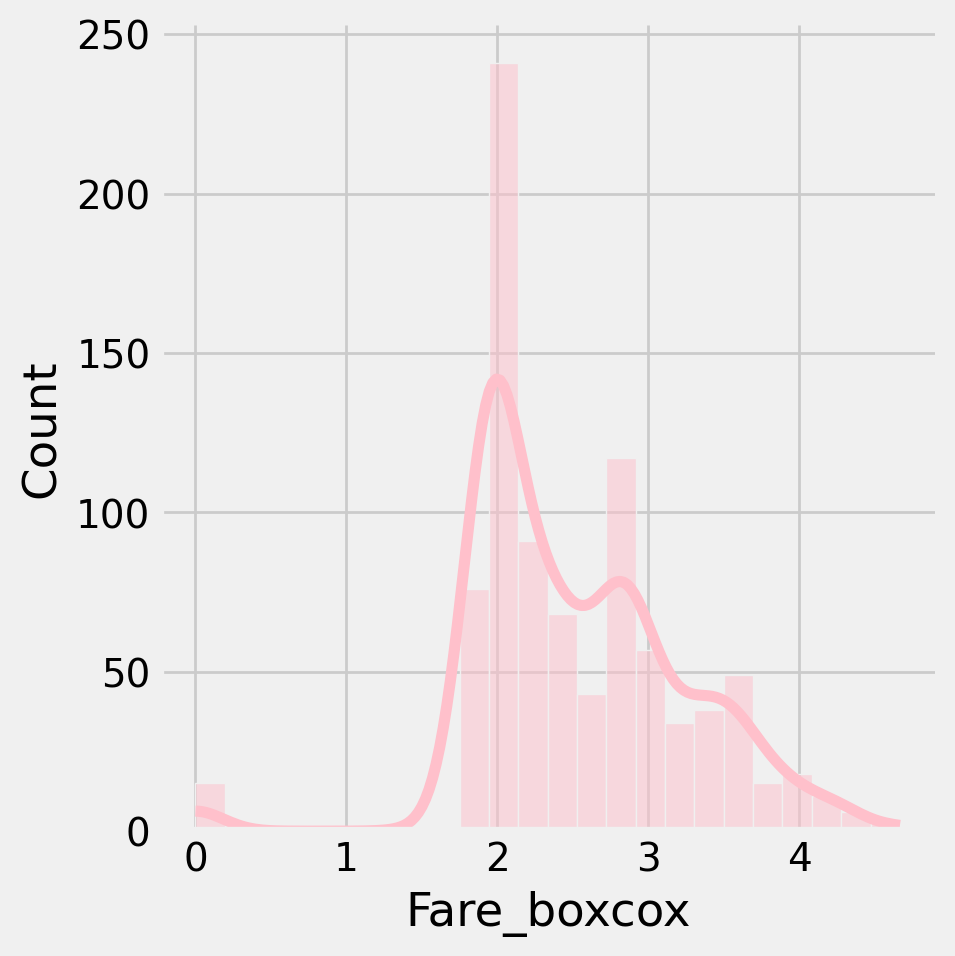

In [ ]:
from scipy import stats

# 0 이상의 값만 Box-Cox 변환
input_train['Fare_boxcox'], fitted_lambda = stats.boxcox(input_train['Fare'] + 1)  # 0 이상이므로 +1

# 변환된 데이터 확인
sns.displot(input_train['Fare_boxcox'], kde=True, color='pink')
plt.show()

box-cox가 더 나은 변환인듯?

In [ ]:
# IQR을 이용한 이상치 탐지 함수
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Fare_boxcox 기준으로 이상치 탐지
outliers_fare_boxcox = detect_outliers_iqr(input_train, 'Fare_boxcox')

# 이상치 출력
print("Fare_boxcox 기준 이상치:")
print(outliers_fare_boxcox)

print("Fare_boxcox 기준 이상치 개수:")
len(outliers_fare_boxcox)


Fare_boxcox 기준 이상치:
     Survived  Pclass                                Name  Sex   Age  SibSp  \
179         0       2                 Leonard, Mr. Lionel    1  36.0      0   
258         1       0                    Ward, Miss. Anna    0  35.0      0   
263         0       0               Harrison, Mr. William    1  40.0      0   
271         1       2        Tornquist, Mr. William Henry    1  25.0      0   
277         0       1         Parkes, Mr. Francis "Frank"    1  29.0      0   
302         0       2     Johnson, Mr. William Cahoone Jr    1  19.0      0   
413         0       1      Cunningham, Mr. Alfred Fleming    1  29.0      0   
466         0       1               Campbell, Mr. William    1  29.0      0   
481         0       1    Frost, Mr. Anthony Wood "Archie"    1  29.0      0   
597         0       2                 Johnson, Mr. Alfred    1  49.0      0   
633         0       0       Parr, Mr. William Henry Marsh    1  37.0      0   
674         0       1          W

18

흠 제거 안 할래
왜냐면 0이랑 512가 극단값이긴 한데 그래도fare니까 의미있지 않을까 ? 피쳐 뭐가 중요한지 생각해보고 나중에 다시 할래..

512는 근데 너무 큰데 대체 뭘까 근데  PC 17755로 티켓 번호가 다 똑같네?


## 새로운 피쳐

### fareperperson

In [ ]:
# 같은 티켓을 공유한 사람 수 계산
input_train['TicketGroupSize'] = input_train.groupby('Ticket')['Ticket'].transform('count')

# 1인당 운임 계산
input_train['FarePerPerson'] = input_train['Fare'] / input_train['TicketGroupSize']

# TicketGroupSize 컬럼 제거 (사용하지 않을 경우)
input_train.drop(columns=['TicketGroupSize'], inplace=True)

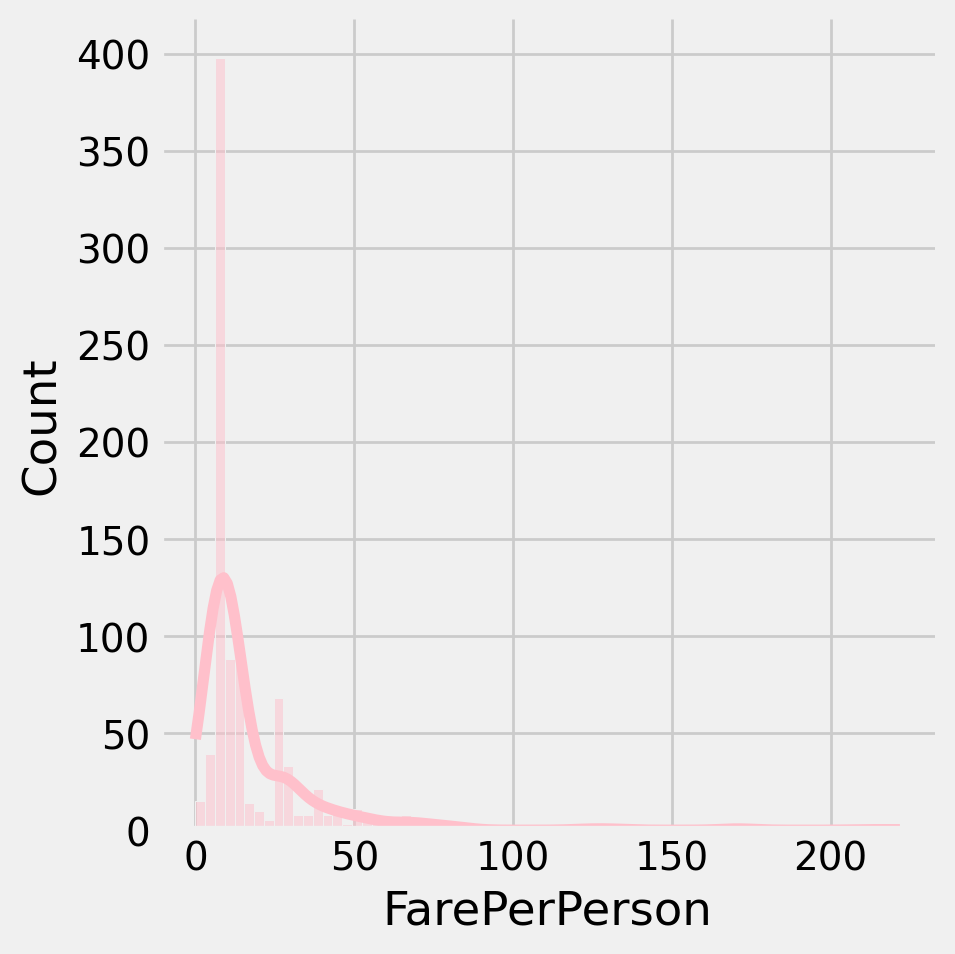

In [ ]:
sns.displot(input_train['FarePerPerson'], kde=True, color='pink') #핑크색 예쁘죵
plt.show()

오호라 꽤나 바꼈네

In [ ]:
# 로그 변환
input_train['FarePerPerson_log'] = np.log1p(input_train['FarePerPerson'])

input_train[['FarePerPerson', 'FarePerPerson_log']].describe()

,FarePerPerson,FarePerPerson_log
count,884.000000,884.000000
mean,17.771273,2.597120
std,21.315652,0.765078
min,0.000000,0.000000
25%,7.750000,2.169054
50%,8.750000,2.277267
75%,22.643750,3.163061
max,221.779200,5.406181


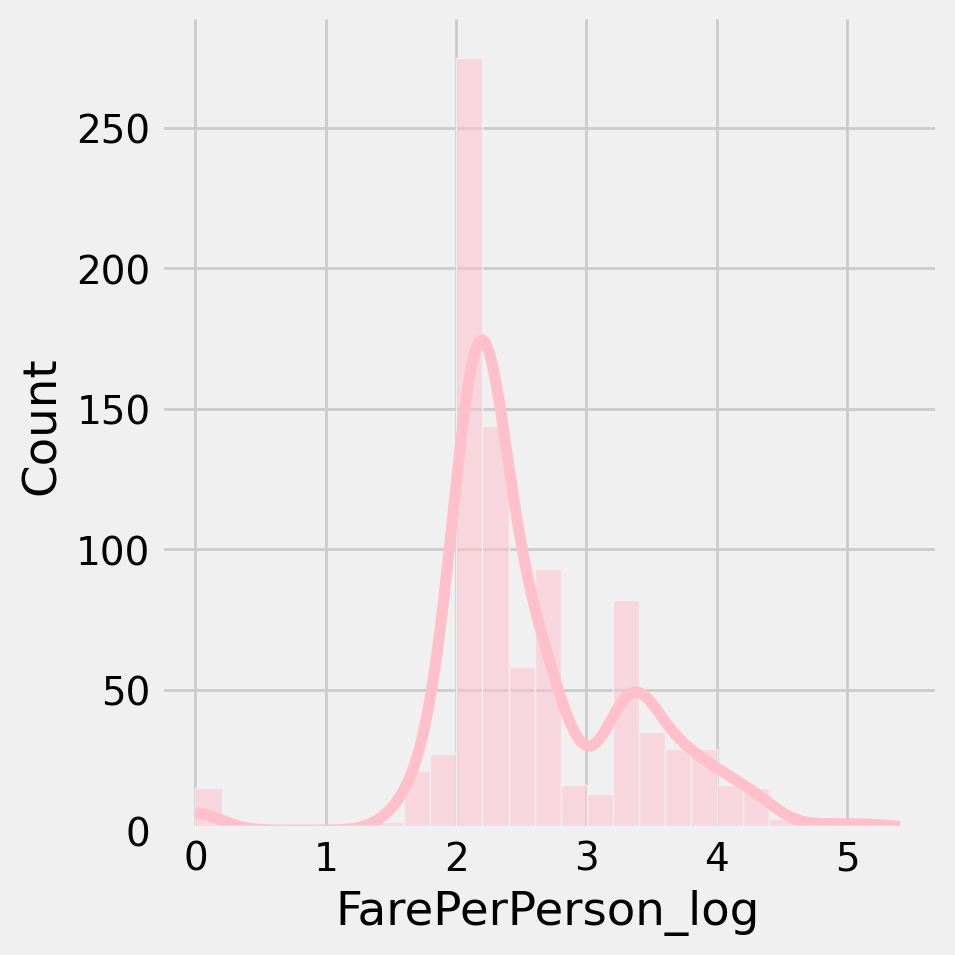

In [ ]:
sns.displot(input_train['FarePerPerson_log'], kde=True, color='pink')
plt.show()

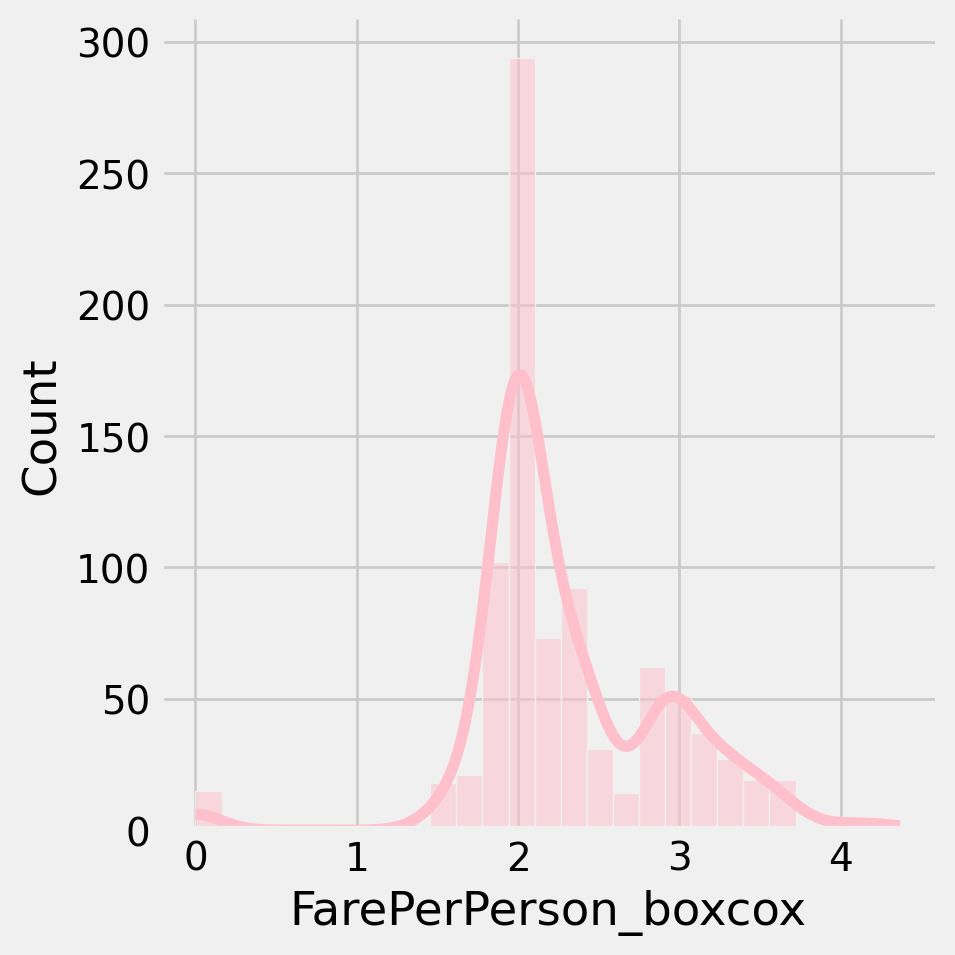

In [ ]:
from scipy import stats

# 0 이상의 값만 Box-Cox 변환
input_train['FarePerPerson_boxcox'], fitted_lambda = stats.boxcox(input_train['FarePerPerson'] + 1)  # 0 이상이므로 +1

# 변환된 데이터 확인
sns.displot(input_train['FarePerPerson_boxcox'], kde=True, color='pink')
plt.show()

In [ ]:
# IQR을 이용한 이상치 탐지 함수
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# FarePerPerson 기준으로 이상치 탐지
outliers_fare_per_person = detect_outliers_iqr(input_train, 'FarePerPerson')

# 이상치 출력
print("FarePerPerson 기준 이상치:")
print(outliers_fare_per_person)

print("FarePerPerson 기준 이상치 개수:")
print(len(outliers_fare_per_person))


FarePerPerson 기준 이상치:
     Survived  Pclass                                               Name  Sex  \
1           1       0  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   
6           0       0                            McCarthy, Mr. Timothy J    1   
27          0       0                     Fortune, Mr. Charles Alexander    1   
31          1       0     Spencer, Mrs. William Augustus (Marie Eugenie)    0   
54          0       0                     Ostby, Mr. Engelhart Cornelius    1   
..        ...     ...                                                ...  ...   
779         1       0  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...    0   
820         1       0  Hays, Mrs. Charles Melville (Clara Jennings Gr...    0   
835         1       0                        Compton, Miss. Sara Rebecca    0   
856         1       0         Wick, Mrs. George Dennick (Mary Hitchcock)    0   
867         0       0               Roebling, Mr. Washington Augustus II    1   

     

In [ ]:
# 변환된 값으로 이상치 탐지
outliers_fare_per_person_boxcox = detect_outliers_iqr(input_train, 'FarePerPerson_boxcox')

print("🔹 FarePerPerson (Box-Cox 변환 후) 기준 이상치 개수:", len(outliers_fare_per_person_boxcox))


🔹 FarePerPerson (Box-Cox 변환 후) 기준 이상치 개수: 24


In [ ]:
# 이상치 값 출력
print(outliers_fare_per_person_boxcox[['FarePerPerson', 'FarePerPerson_boxcox']])

     FarePerPerson  FarePerPerson_boxcox
118       123.7604              3.984961
179         0.0000              0.000000
258       170.7764              4.197343
263         0.0000              0.000000
271         0.0000              0.000000
277         0.0000              0.000000
299       123.7604              3.984961
302         0.0000              0.000000
311       131.1875              4.023778
377       211.5000              4.335574
413         0.0000              0.000000
466         0.0000              0.000000
481         0.0000              0.000000
527       221.7792              4.365941
597         0.0000              0.000000
633         0.0000              0.000000
674         0.0000              0.000000
679       170.7764              4.197343
732         0.0000              0.000000
737       170.7764              4.197343
742       131.1875              4.023778
806         0.0000              0.000000
815         0.0000              0.000000
822         0.00

512같은 개극단값들만 나온 게 아니라 그래도 다른 값들도 골고루 이상치로 나옴 iqr이 효과적이라는 건 알겠긴 한데 제거나 변환을 해야할까..?

생존률은 어떨까?

In [ ]:
# FarePerPerson이 0인 승객들의 생존률 확인
print(input_train[input_train['FarePerPerson'] == 0]['Survived'].value_counts(normalize=True))


Survived
0    0.933333
1    0.066667
Name: proportion, dtype: float64


In [ ]:
# 극단적으로 높은 FarePerPerson을 가진 승객들의 생존률 확인
high_fare = input_train[input_train['FarePerPerson'] > input_train['FarePerPerson'].quantile(0.99)]
print(high_fare['Survived'].value_counts(normalize=True))


Survived
1    0.666667
0    0.333333
Name: proportion, dtype: float64


fare이 pclass와 비슷한 계열이긴하지만 강력하게 생존률에 영향을 주는 거 같네

In [ ]:
# Fare와 FarePerPerson의 상관관계 계산
correlation = input_train[['Fare', 'FarePerPerson']].corr()
print(correlation)


                   Fare  FarePerPerson
Fare           1.000000       0.838613
FarePerPerson  0.838613       1.000000


상관관계 개높네 뭐 그럴줄 알았으니까 그러면 새로 만든 걸로 넣어볼까 fare drop 하고

### family size

In [ ]:
# FamilySize 변수 생성
input_train['FamilySize'] = input_train['SibSp'] + input_train['Parch'] + 1

In [ ]:
# 이름에서 Title 추출
input_train['Title'] = input_train['Name'].str.extract(' ([A-Za-z]+)\.')

# Title을 대표적인 그룹으로 변환
title_mapping = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 'Mlle': 'Miss',
    'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare', 'Jonkheer': 'Rare',
    'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs', 'Capt': 'Rare', 'Sir': 'Rare'
}

input_train['Title'] = input_train['Title'].map(title_mapping)

In [ ]:
# FamilyStatus 생성
def get_family_status(row):
    if row['FamilySize'] == 1:
        return 'Alone_' + row['Title']  # 혼자 탄 경우
    elif row['FamilySize'] > 1 and row['Title'] in ['Mr', 'Mrs']:
        return 'WithFamily_' + row['Title']  # 가족과 함께한 성인
    elif row['FamilySize'] > 1 and row['Title'] == 'Master':
        return 'WithFamily_Child'  # 가족과 함께한 어린 남자아이
    else:
        return 'WithFamily_Other'  # 가족과 함께한 기타 경우

input_train['FamilyStatus'] = input_train.apply(get_family_status, axis=1)


In [ ]:
# FamilyStatus 변수별 개수 및 비율 계산 함수
def analyze_family_status(df):
    family_status_counts = df['FamilyStatus'].value_counts()
    family_status_proportion = df['FamilyStatus'].value_counts(normalize=True) * 100

    # 데이터프레임으로 정리
    family_status_df = pd.DataFrame({
        'Count': family_status_counts,
        'Proportion (%)': family_status_proportion
    })

    return family_status_df

# 결과 출력
family_status_summary = analyze_family_status(input_train)
print(family_status_summary)


                  Count  Proportion (%)
FamilyStatus                           
Alone_Mr            391       44.230769
WithFamily_Mr       120       13.574661
WithFamily_Mrs      105       11.877828
Alone_Miss          103       11.651584
WithFamily_Other     88        9.954751
WithFamily_Child     40        4.524887
Alone_Mrs            21        2.375566
Alone_Rare           16        1.809955


생각보다 분류가 잘 됐네.. 인코딩해서 vif 봐야징~

In [ ]:
# FamilyStatus를 One-Hot Encoding
input_train = pd.get_dummies(input_train, columns=['FamilyStatus'], drop_first=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1️⃣ VIF 계산을 위한 컬럼 선택 (One-Hot Encoding된 FamilyStatus 포함)
features = ['FamilySize'] + list(input_train.filter(like='FamilyStatus_').columns)

# 2️⃣ NaN 값이 있으면 제거하고, 데이터 타입 변환 (float로 변환)
X_vif = input_train[features].copy()
X_vif = X_vif.fillna(0)  # 결측값을 0으로 채움
X_vif = X_vif.astype(float)  # 데이터 타입 변환

# 3️⃣ 다중공선성 확인 (VIF 계산)
vif_data = pd.DataFrame()
vif_data["Feature"] = features
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(features))]

# 4️⃣ 결과 출력
print(vif_data)


                         Feature       VIF
0                     FamilySize  4.688022
1          FamilyStatus_Alone_Mr  1.331228
2         FamilyStatus_Alone_Mrs  1.017790
3        FamilyStatus_Alone_Rare  1.013554
4  FamilyStatus_WithFamily_Child  1.740583
5     FamilyStatus_WithFamily_Mr  1.854925
6    FamilyStatus_WithFamily_Mrs  1.706878
7  FamilyStatus_WithFamily_Other  2.023065


낫배드네 10 안 넘으니까 다~ 그러면 나머지 드랍하고 변수만 남겨둬야징

### age 범주

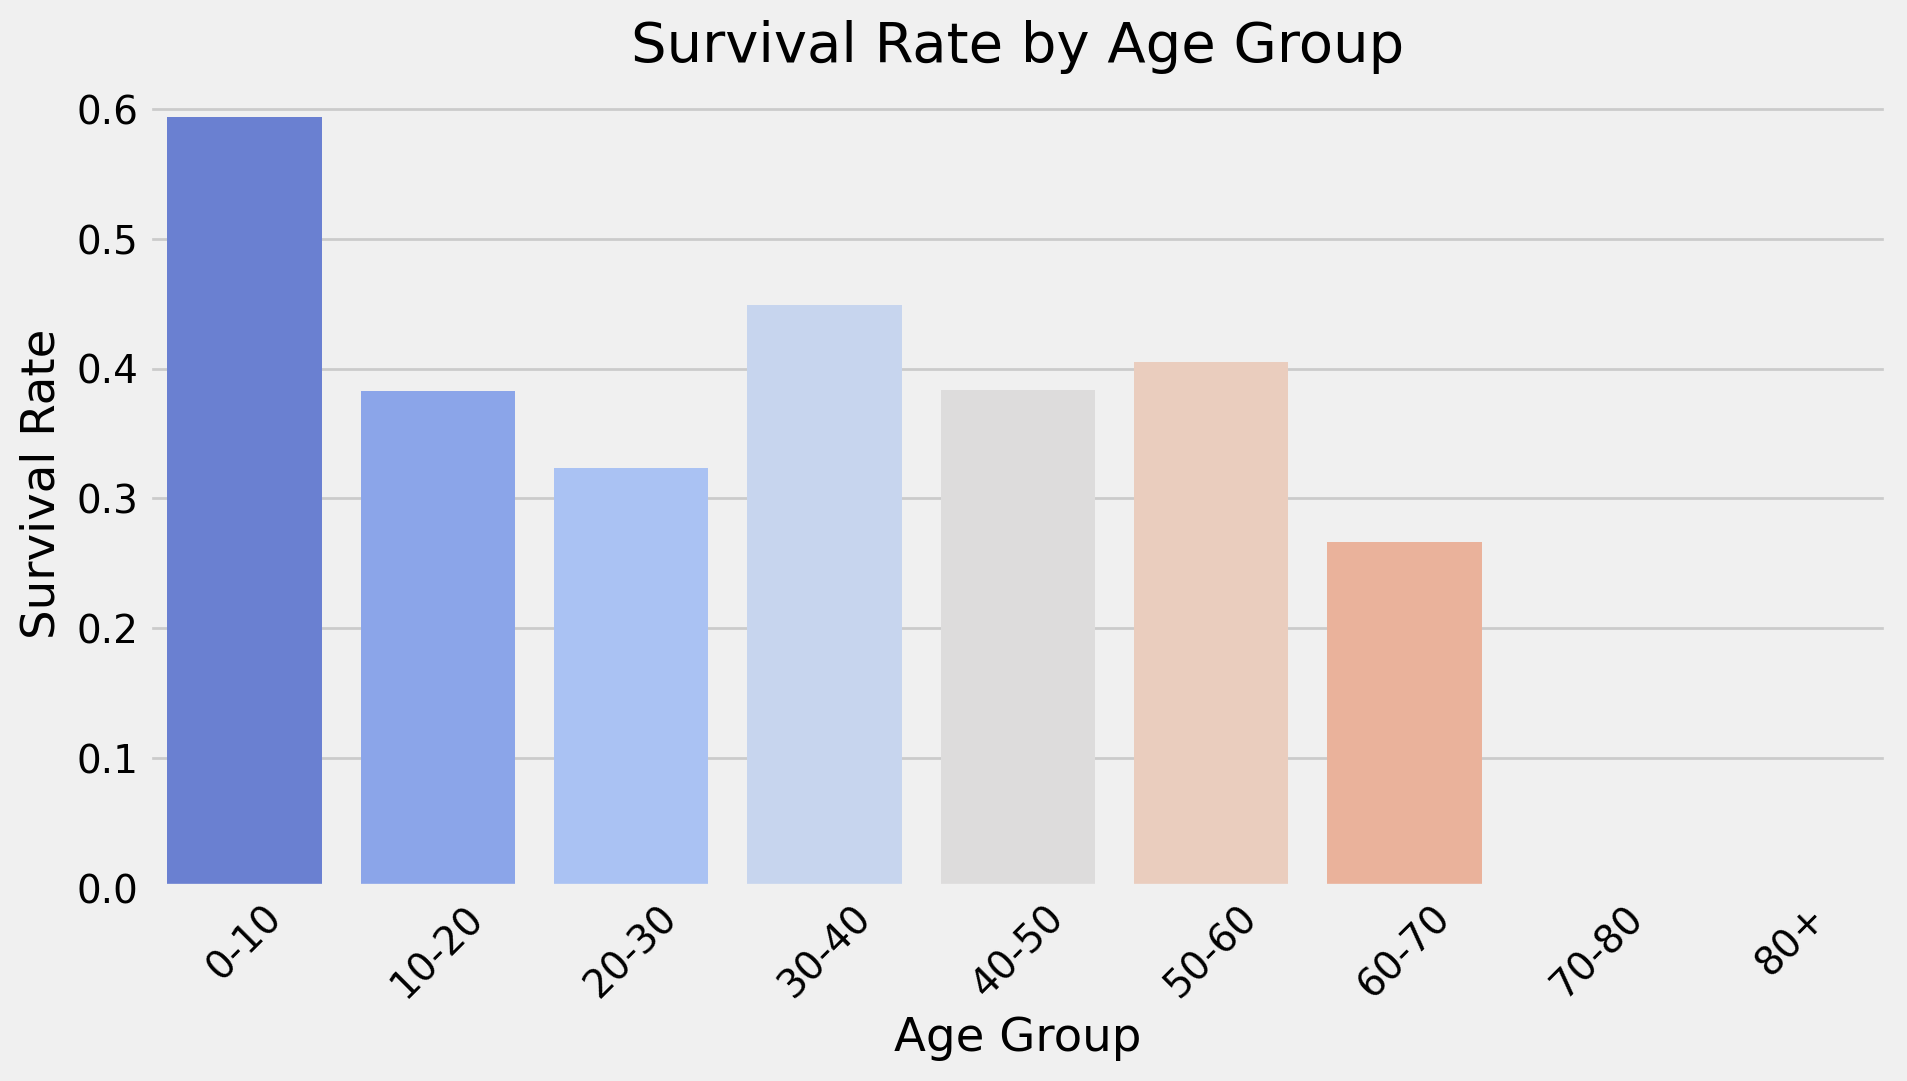

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Age를 일정한 범주로 나누고 생존률 계산
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

input_train['AgeGroup'] = pd.cut(input_train['Age'], bins=age_bins, labels=age_labels)

# 범주별 생존률 계산
age_survival = input_train.groupby('AgeGroup')['Survived'].mean()

# 결과 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=age_survival.index, y=age_survival.values, palette='coolwarm')
plt.xlabel("Age Group")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Age Group")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd

# 연령대를 생존률 패턴에 맞게 범주형으로 변환
bins = [0, 10, 30, 50, 70, 100]  # 나이 구간 설정
labels = ['Child', 'YoungAdult', 'MiddleAged', 'Senior', 'Elderly']  # 범주 레이블

input_train['AgeGroup'] = pd.cut(input_train['Age'], bins=bins, labels=labels)

# One-Hot Encoding
input_train = pd.get_dummies(input_train, columns=['AgeGroup'], drop_first=True)

# 결과 확인
print(input_train.head())


   Survived  Pclass                                               Name  Sex  \
0         0       2                            Braund, Mr. Owen Harris    1   
1         1       0  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   
2         1       2                             Heikkinen, Miss. Laina    0   
3         1       0       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   
4         0       2                           Allen, Mr. William Henry    1   

    Age  SibSp  Parch            Ticket     Fare  Embarked_C  ...  \
0  22.0      1      0         A/5 21171   7.2500       False  ...   
1  38.0      1      0          PC 17599  71.2833        True  ...   
2  26.0      0      0  STON/O2. 3101282   7.9250       False  ...   
3  35.0      1      0            113803  53.1000       False  ...   
4  35.0      0      0            373450   8.0500       False  ...   

   FamilyStatus_Alone_Mrs  FamilyStatus_Alone_Rare  \
0                   False                    False   
1 

In [ ]:
# 컬럼 목록 출력
print(input_train.columns)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_log',
       'Fare_boxcox', 'FarePerPerson', 'FarePerPerson_log',
       'FarePerPerson_boxcox', 'FamilySize', 'Title', 'FamilyStatus_Alone_Mr',
       'FamilyStatus_Alone_Mrs', 'FamilyStatus_Alone_Rare',
       'FamilyStatus_WithFamily_Child', 'FamilyStatus_WithFamily_Mr',
       'FamilyStatus_WithFamily_Mrs', 'FamilyStatus_WithFamily_Other',
       'AgeGroup_YoungAdult', 'AgeGroup_MiddleAged', 'AgeGroup_Senior',
       'AgeGroup_Elderly'],
      dtype='object')


## 피쳐 제거

In [ ]:
drop_cols = [
    'Name', 'Ticket',  # 고유 식별자
    'Fare', 'Fare_log', 'FarePerPerson_log',  # Fare 중복 제거
    'Age', 'Title',  # Age 대신 AgeGroup 사용, Title 제거
    'SibSp', 'Parch',  # FamilySize, FamilyStatus로 대체
    'Embarked_C','Embarked_Q', 'Embarked_S'
]

# 드랍 적용
input_train = input_train.drop(columns=drop_cols)

# 확인
print(input_train.columns)



Index(['Survived', 'Pclass', 'Sex', 'Fare_boxcox', 'FarePerPerson',
       'FarePerPerson_boxcox', 'FamilySize', 'FamilyStatus_Alone_Mr',
       'FamilyStatus_Alone_Mrs', 'FamilyStatus_Alone_Rare',
       'FamilyStatus_WithFamily_Child', 'FamilyStatus_WithFamily_Mr',
       'FamilyStatus_WithFamily_Mrs', 'FamilyStatus_WithFamily_Other',
       'AgeGroup_YoungAdult', 'AgeGroup_MiddleAged', 'AgeGroup_Senior',
       'AgeGroup_Elderly'],
      dtype='object')


## 스케일

In [ ]:
input_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 884 entries, 0 to 890
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Survived                       884 non-null    int64  
 1   Pclass                         884 non-null    int64  
 2   Sex                            884 non-null    int64  
 3   Fare_boxcox                    884 non-null    float64
 4   FarePerPerson                  884 non-null    float64
 5   FarePerPerson_boxcox           884 non-null    float64
 6   FamilySize                     884 non-null    int64  
 7   FamilyStatus_Alone_Mr          884 non-null    bool   
 8   FamilyStatus_Alone_Mrs         884 non-null    bool   
 9   FamilyStatus_Alone_Rare        884 non-null    bool   
 10  FamilyStatus_WithFamily_Child  884 non-null    bool   
 11  FamilyStatus_WithFamily_Mr     884 non-null    bool   
 12  FamilyStatus_WithFamily_Mrs    884 non-null    bool   


스케일링은 안 할 거야 왜냐면 트리 기반 모델을 바탕으로 예측할 건데 어차피 상대적 거리로 판단하기 때문에 스케일링을 할 필요가 없엉 선형적 모델은 필요함!

# 데이터 분할

훈련 데이터와 테스트 데이터로 나누어 모델을 평가할 수 있도록 합니다.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold 설정 (K=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(input_train.drop(columns=['Survived']), input_train['Survived']):
    X_train, X_test = input_train.iloc[train_index], input_train.iloc[test_index]
    y_train, y_test = input_train['Survived'].iloc[train_index], input_train['Survived'].iloc[test_index]

# 결과 확인
print(f"훈련 데이터 크기: {X_train.shape}, 테스트 데이터 크기: {X_test.shape}")


훈련 데이터 크기: (708, 18), 테스트 데이터 크기: (176, 18)


# 모델 활용

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectFromModel

# ✅ 1. Stratified K-Fold 설정 (교차 검증)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ 2. 트리 기반 모델 설정 (과적합 방지 적용)
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, reg_alpha=0.1, reg_lambda=0.1, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, reg_alpha=0.1, random_state=42)
}

# ✅ 3. Feature Selection (불필요한 변수 제거)
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
feature_selector.fit(X_train, y_train)

X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

print(f"📌 Feature Selection 적용 후 특성 개수: {X_train_selected.shape[1]}")

# ✅ 4. 모델 학습 및 평가
results = {}

for name, model in models.items():
    print(f"\n🔹 {name} 모델 학습 중...")

    # 모델 학습
    model.fit(X_train_selected, y_train)

    # 예측
    y_pred = model.predict(X_test_selected)

    # 정확도 평가
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # K-Fold 교차 검증
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=skf)
    print(f"{name} K-Fold Accuracy: {cv_scores.mean():.4f}")

# ✅ 5. 가장 성능 좋은 모델 선택
best_model = max(results, key=results.get)
print(f"\n🚀 최적 모델: {best_model} (Accuracy: {results[best_model]:.4f})")


📌 Feature Selection 적용 후 특성 개수: 2

🔹 RandomForest 모델 학습 중...
RandomForest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        68

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

RandomForest K-Fold Accuracy: 1.0000

🔹 XGBoost 모델 학습 중...
XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        68

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

XGBoost K-Fold Accuracy: 1.0000

🔹 LightGBM 모델 학습 중...
[LightGBM] [Info] Number of positive: 273, number of negative: 435
[LightGBM] [Info] Auto-choosing col-wise multi-th

In [ ]:
!pip install --upgrade numpy catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
